In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_quality_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = load_air_quality_data()
print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

dataframe shape (9357, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date_Time    9357 non-null   object 
 1   CO_true      9357 non-null   float64
 2   CO_sensor    9357 non-null   float64
 3   NMHC_true    9357 non-null   float64
 4   C6H6_true    9357 non-null   float64
 5   NMHC_sensor  9357 non-null   float64
 6   NOX_true     9357 non-null   float64
 7   NOX_sensor   9357 non-null   float64
 8   NO2_true     9357 non-null   float64
 9   NO2_sensor   9357 non-null   float64
 10  O3_sensor    9357 non-null   float64
 11  T            9357 non-null   float64
 12  RH           9357 non-null   float64
 13  AH           9357 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1023.6+ KB
None


,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
dataframe = (
    load_air_quality_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="6H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (9357, 14)
set_index: DF Shape (9357, 13)
interpolate_columns: DF Shape (9357, 13)
resample_Data: DF Shape (1560, 13)
dataframe shape (1560, 13)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560 entries, 2004-03-10 18:00:00 to 2005-04-04 12:00:00
Freq: 6H
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CO_true      1560 non-null   float64
 1   CO_sensor    1560 non-null   float64
 2   NMHC_true    1560 non-null   float64
 3   C6H6_true    1560 non-null   float64
 4   NMHC_sensor  1560 non-null   float64
 5   NOX_true     1560 non-null   float64
 6   NOX_sensor   1560 non-null   float64
 7   NO2_true     1560 non-null   float64
 8   NO2_sensor   1560 non-null   float64
 9   O3_sensor    1560 non-null   float64
 10  T            1560 non-null   float64
 11  RH           1560 non-null   float64
 12  AH           1560 non-null   float64
dtypes: float64(13)
memory usage: 170.6 KB
None

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,1.966667,1316.500000,86.500000,8.450000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,12.033333,54.900000,0.765633
2004-03-11 00:00:00,-32.600000,1083.666667,21.166667,2.216667,595.166667,1.000000,1655.833333,12.500000,1259.333333,575.166667,10.683333,58.900000,0.755017
2004-03-11 06:00:00,1.533333,1215.333333,52.666667,5.600000,778.166667,107.000000,1331.500000,88.833333,1411.333333,810.500000,10.550000,58.666667,0.746217
2004-03-11 12:00:00,2.283333,1313.000000,102.000000,8.716667,923.666667,179.500000,1106.500000,121.166667,1604.166667,917.833333,8.933333,73.816667,0.843533
2004-03-11 18:00:00,4.033333,1364.666667,242.166667,15.383333,1110.833333,232.666667,1015.166667,127.000000,1816.500000,1237.500000,9.183333,64.916667,0.758300


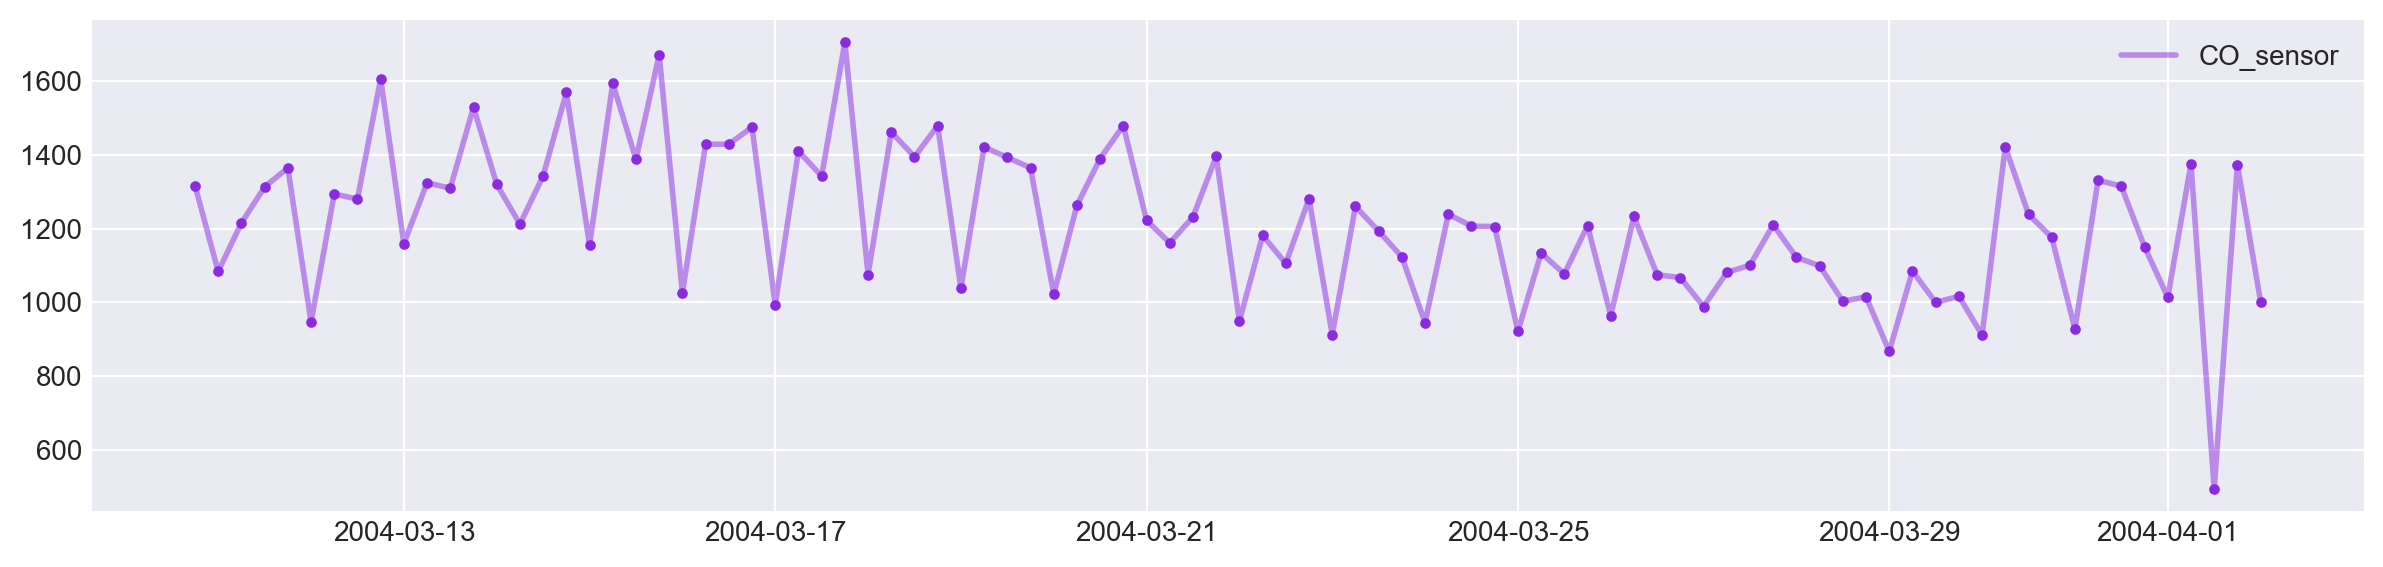

In [5]:
show_dataset(dataframe[:90], columns=["CO_sensor"])

In [6]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "CO_sensor"
TEST_SIZE = 30

In [7]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (1530, 13)
Test  Size after Test_Train Split: (30, 13) 
train_data shape after Feature Union (1530, 32)
test_data shape after Feature Union (30, 32)
train_data shape after Null Removal (1528, 32)
test_data shape after Null Removal (30, 32)


,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-28 06:00:00,1.166667,1049.000000,-200.0,4.000000,703.666667,172.166667,772.000000,93.833333,1277.000000,835.333333,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-28 12:00:00,1.383333,1080.166667,-200.0,4.400000,729.833333,168.000000,756.500000,92.666667,1248.500000,691.000000,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-28 18:00:00,2.416667,1182.166667,-200.0,8.450000,911.666667,330.500000,624.833333,141.000000,1355.166667,1072.333333,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-29 00:00:00,-32.616667,936.833333,-200.0,2.383333,602.500000,104.666667,917.333333,68.333333,1155.000000,747.833333,...,29.0,13.0,0.0,1.0,-0.663634,-0.748058,0.14112,-0.989992,0.035398,0.999373
2005-03-29 06:00:00,3.183333,1302.833333,-200.0,15.033333,1126.166667,458.333333,511.666667,132.166667,1598.166667,1370.833333,...,29.0,13.0,0.0,1.0,-0.663634,-0.748058,0.14112,-0.989992,0.035398,0.999373


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.881 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.840 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.859 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.896 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.842 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.882 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.894 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.830 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.897 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.892 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.819 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

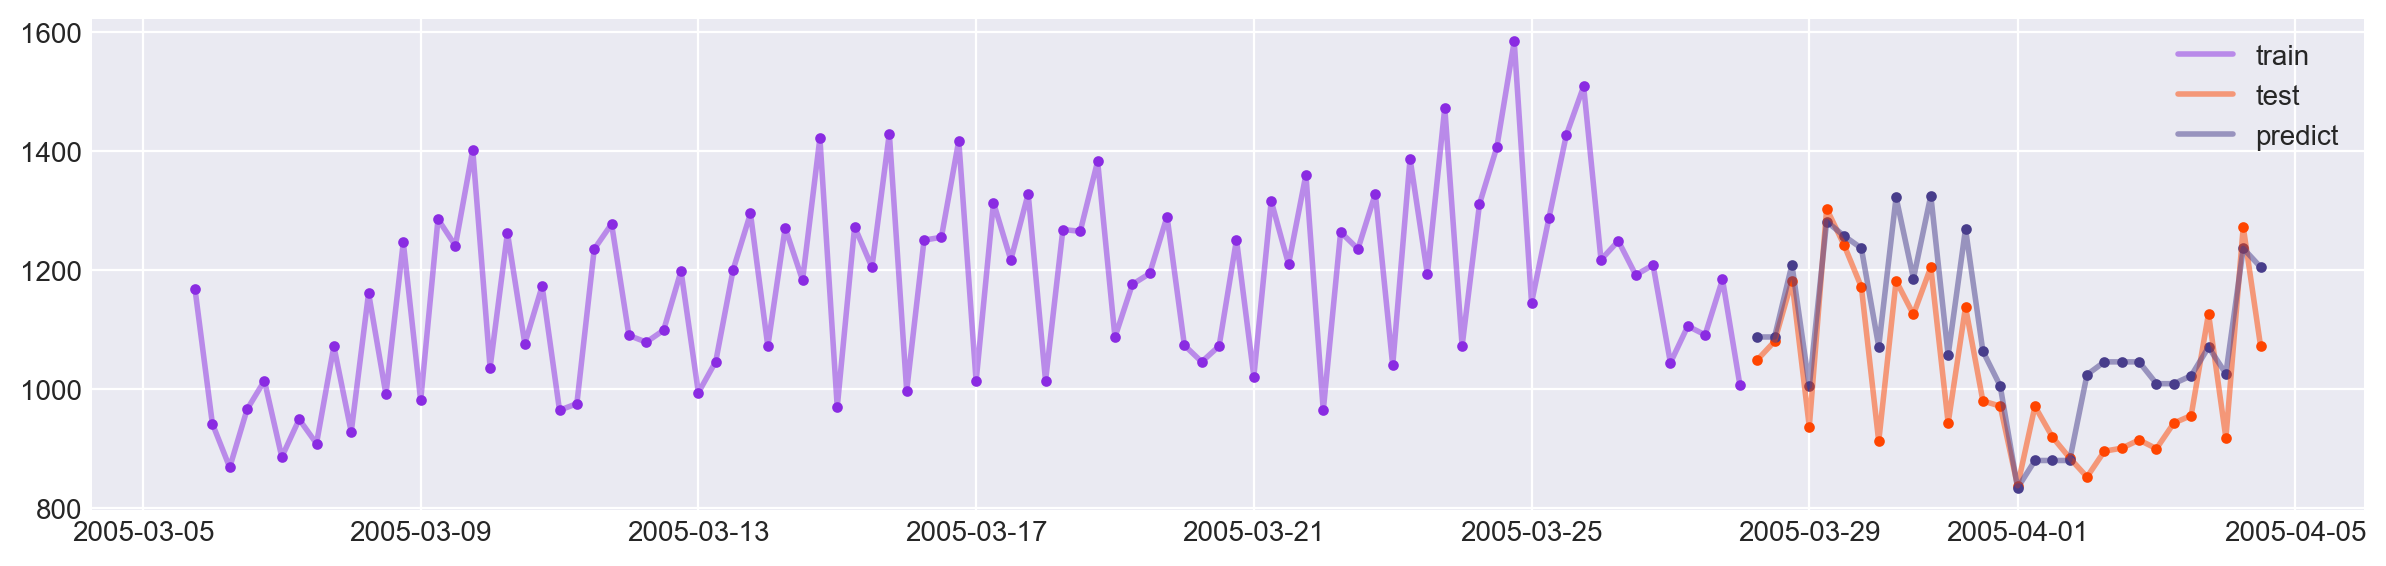

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  6  iterations


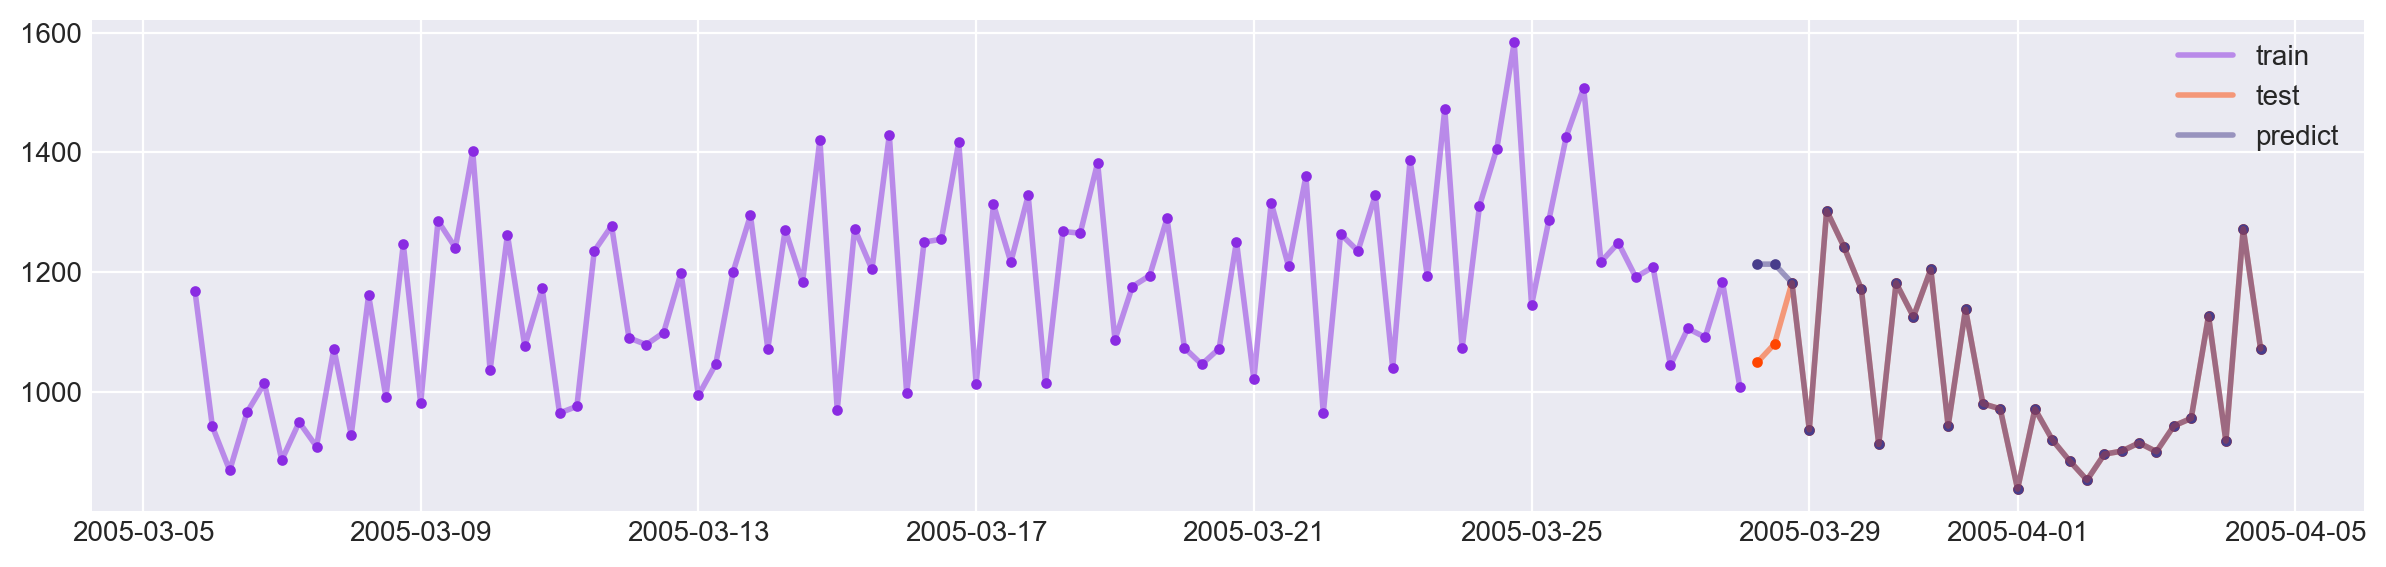

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [13]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

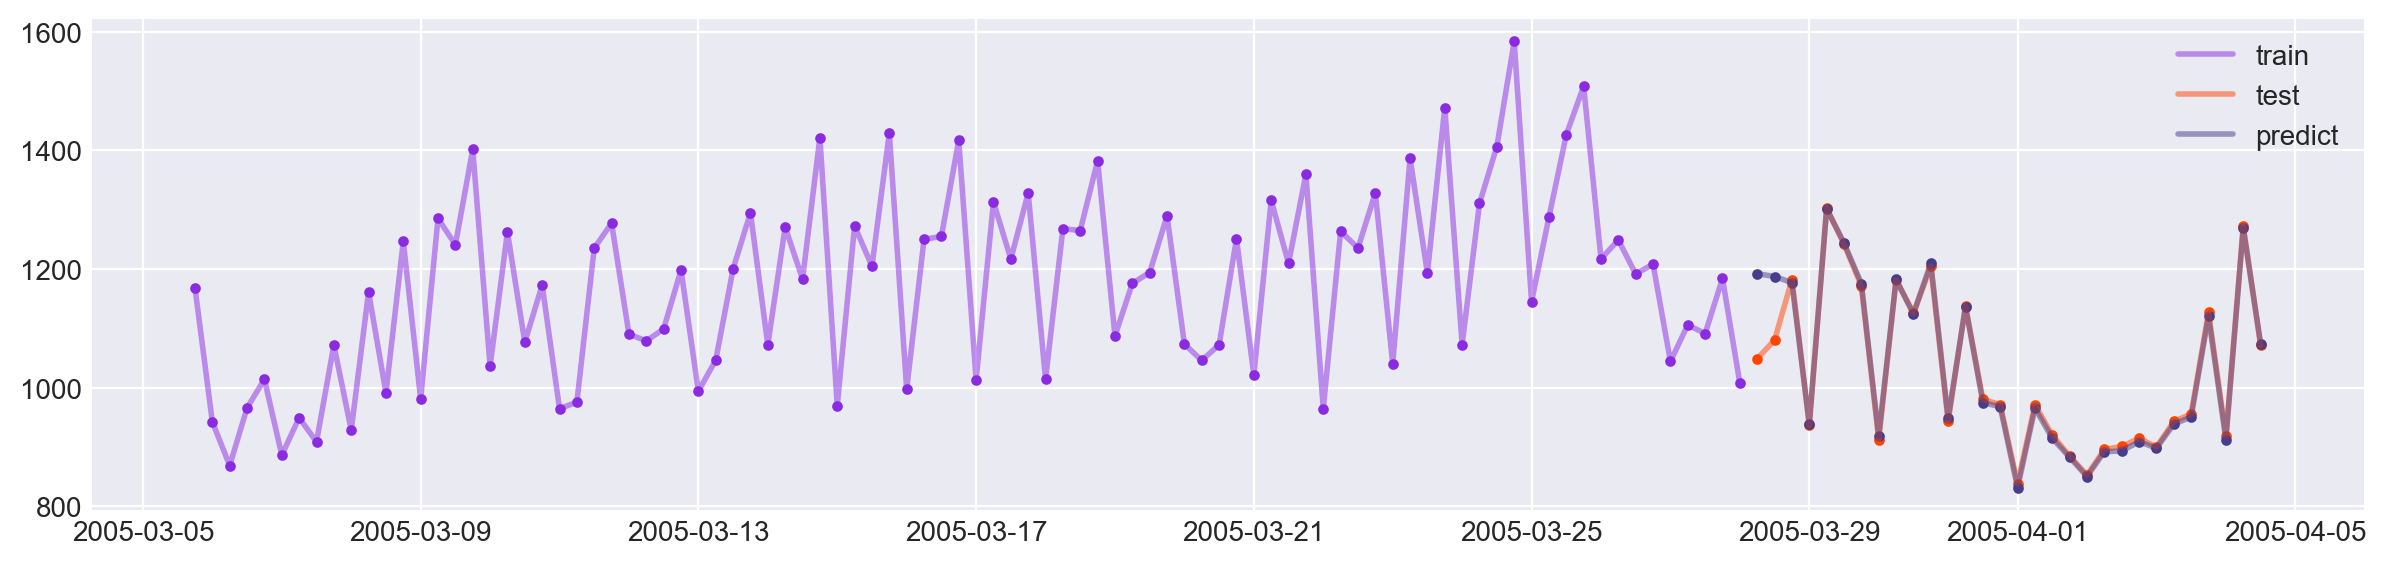

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.955 total time=   3.1s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.956 total time=  14.7s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.978 total time=  21.2s
0.9631924042162615 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}


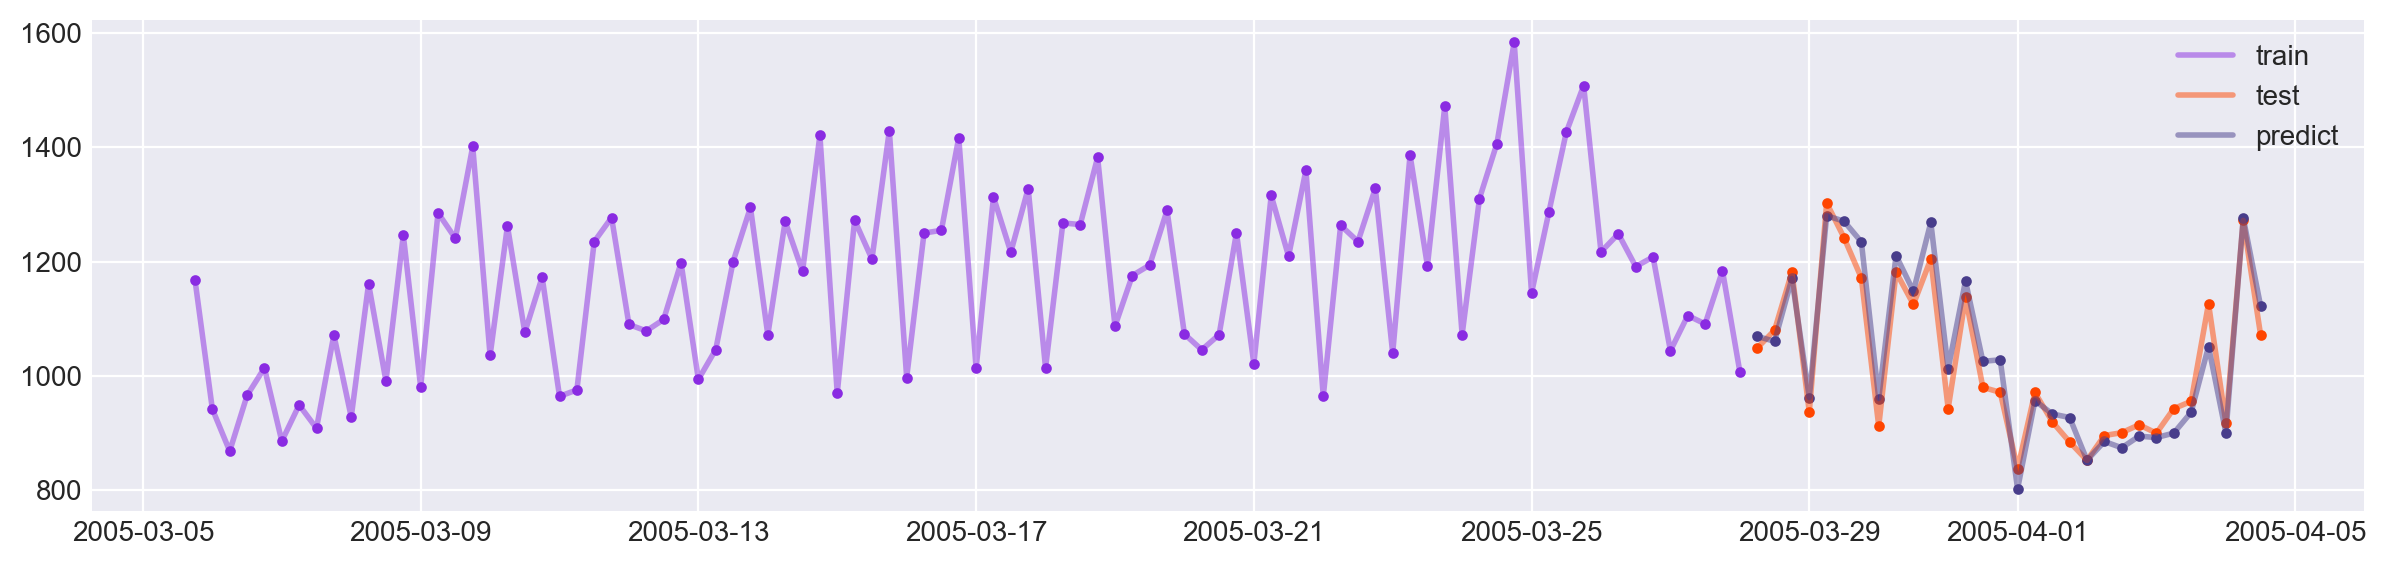

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:1051.56258	validation_1-mae:1015.67979
[1]	validation_0-mae:1041.09882	validation_1-mae:1005.72264
[2]	validation_0-mae:1030.74007	validation_1-mae:995.88489
[3]	validation_0-mae:1020.48379	validation_1-mae:986.25442
[4]	validation_0-mae:1010.32943	validation_1-mae:976.71071
[5]	validation_0-mae:1000.27609	validation_1-mae:967.16455
[6]	validation_0-mae:990.32370	validation_1-mae:957.71344
[7]	validation_0-mae:980.47600	validation_1-mae:948.46437
[8]	validation_0-mae:970.72069	validation_1-mae:939.20080
[9]	validation_0-mae:961.06138	validation_1-mae:930.07909
[10]	validation_0-mae:951.49756	validation_1-mae:921.00248
[11]	validation_0-mae:942.03538	validation_1-mae:912.07139
[12]	validation_0-mae:932.66083	validation_1-mae:903.12023
[13]	validation_0-mae:923.38267	validation_1-mae:894.29386
[14]	validation_0-mae:914.20086	validation_1-mae:885.66583
[15]	validation_0-mae:905.11103	validation_1-mae:877.03992
[16]	validation_0-mae:896.10705	validation_1-mae:868.47565

[138]	validation_0-mae:265.46596	validation_1-mae:254.40401
[139]	validation_0-mae:262.83932	validation_1-mae:251.82945
[140]	validation_0-mae:260.24175	validation_1-mae:249.21711
[141]	validation_0-mae:257.66887	validation_1-mae:246.59293
[142]	validation_0-mae:255.12115	validation_1-mae:244.00676
[143]	validation_0-mae:252.59720	validation_1-mae:241.48366
[144]	validation_0-mae:250.10206	validation_1-mae:238.97214
[145]	validation_0-mae:247.63630	validation_1-mae:236.51640
[146]	validation_0-mae:245.19058	validation_1-mae:234.04500
[147]	validation_0-mae:242.76806	validation_1-mae:231.53425
[148]	validation_0-mae:240.36579	validation_1-mae:229.12860
[149]	validation_0-mae:237.99152	validation_1-mae:226.67333
[150]	validation_0-mae:235.64114	validation_1-mae:224.29635
[151]	validation_0-mae:233.31112	validation_1-mae:222.00000
[152]	validation_0-mae:231.00460	validation_1-mae:219.64479
[153]	validation_0-mae:228.72438	validation_1-mae:217.35497
[154]	validation_0-mae:226.46499	validat

[277]	validation_0-mae:67.41306	validation_1-mae:54.36066
[278]	validation_0-mae:66.77090	validation_1-mae:53.76809
[279]	validation_0-mae:66.13299	validation_1-mae:53.21649
[280]	validation_0-mae:65.50414	validation_1-mae:52.58818
[281]	validation_0-mae:64.88189	validation_1-mae:51.98042
[282]	validation_0-mae:64.26751	validation_1-mae:51.41994
[283]	validation_0-mae:63.66107	validation_1-mae:50.86497
[284]	validation_0-mae:63.05572	validation_1-mae:50.36971
[285]	validation_0-mae:62.46270	validation_1-mae:49.82385
[286]	validation_0-mae:61.87690	validation_1-mae:49.30599
[287]	validation_0-mae:61.29711	validation_1-mae:48.76503
[288]	validation_0-mae:60.72152	validation_1-mae:48.23685
[289]	validation_0-mae:60.15515	validation_1-mae:47.75938
[290]	validation_0-mae:59.59099	validation_1-mae:47.30041
[291]	validation_0-mae:59.03712	validation_1-mae:46.82520
[292]	validation_0-mae:58.49109	validation_1-mae:46.35499
[293]	validation_0-mae:57.95167	validation_1-mae:45.96330
[294]	validati

[419]	validation_0-mae:23.98200	validation_1-mae:31.53181
[420]	validation_0-mae:23.86747	validation_1-mae:31.50477
[421]	validation_0-mae:23.74502	validation_1-mae:31.50261
[422]	validation_0-mae:23.62359	validation_1-mae:31.54952
[423]	validation_0-mae:23.52654	validation_1-mae:31.56183
[424]	validation_0-mae:23.40797	validation_1-mae:31.66521
[425]	validation_0-mae:23.29017	validation_1-mae:31.71115
[426]	validation_0-mae:23.18495	validation_1-mae:31.72336
[427]	validation_0-mae:23.07230	validation_1-mae:31.78964
[428]	validation_0-mae:22.96128	validation_1-mae:31.88963
[429]	validation_0-mae:22.86111	validation_1-mae:31.86972
[430]	validation_0-mae:22.76148	validation_1-mae:31.91753
[431]	validation_0-mae:22.65539	validation_1-mae:31.98074
[432]	validation_0-mae:22.55050	validation_1-mae:32.07861
[433]	validation_0-mae:22.45605	validation_1-mae:32.05911
[434]	validation_0-mae:22.36344	validation_1-mae:32.15603
[435]	validation_0-mae:22.26302	validation_1-mae:32.21738
[436]	validati

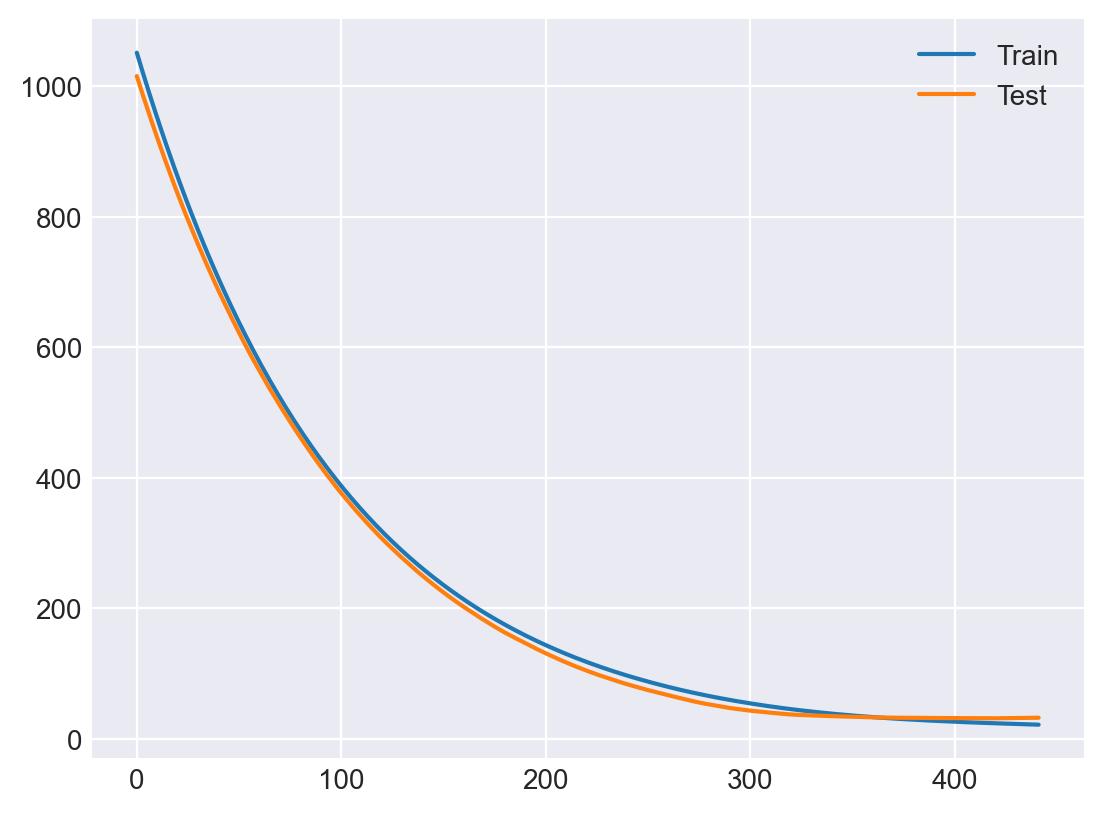

In [17]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

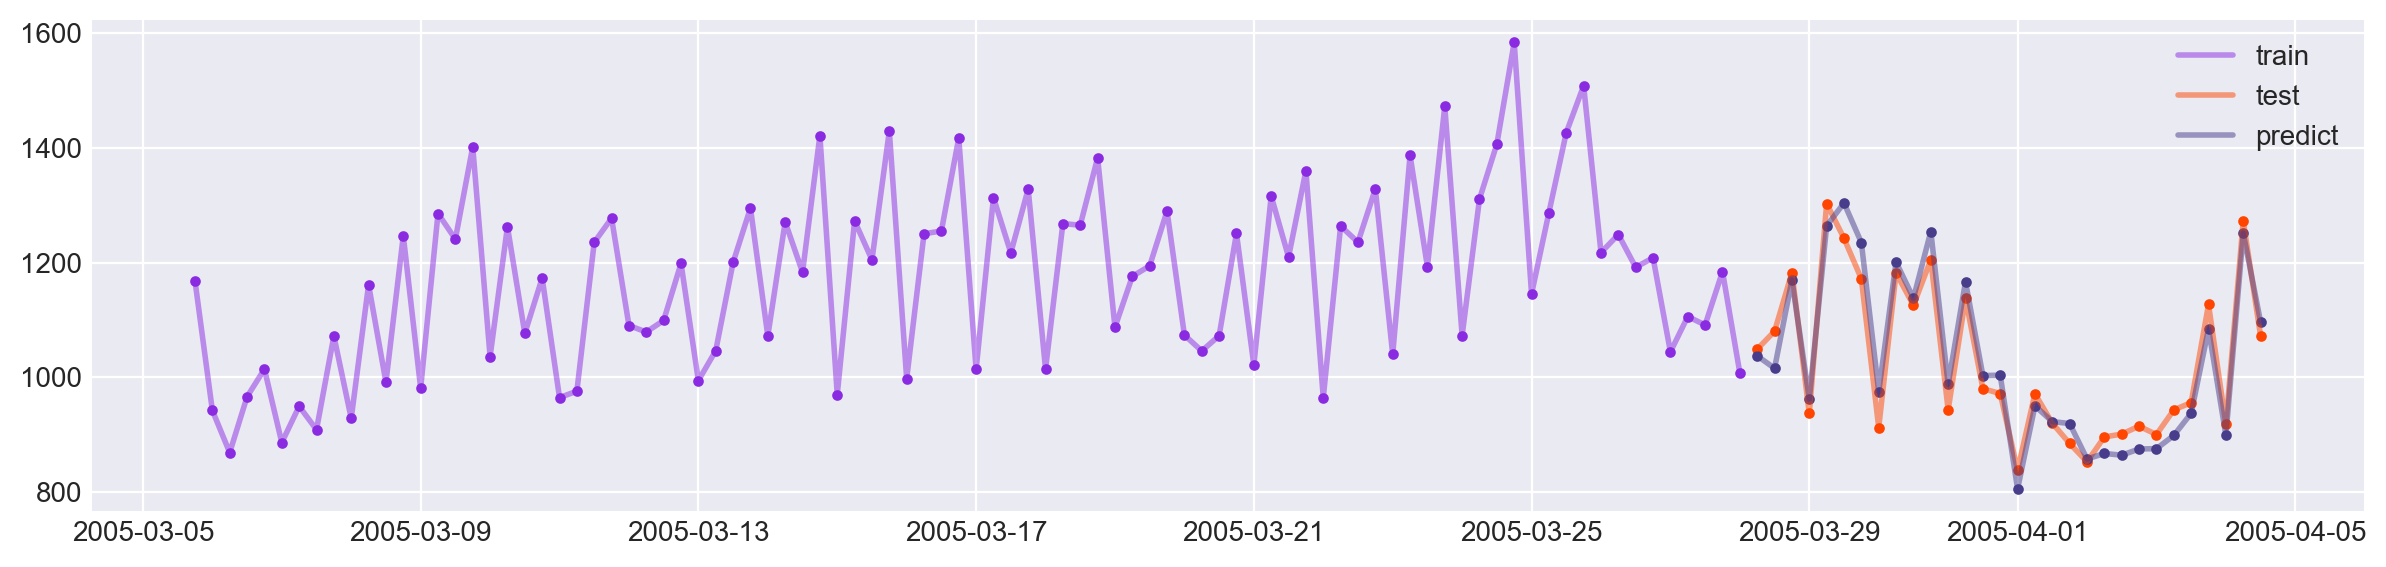

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [19]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 178.425	training's l2: 76683.7	valid_1's l1: 111.613	valid_1's l2: 15100.7
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 161.689	training's l2: 62721.1	valid_1's l1: 100.88	valid_1's l2: 12308.5
[3]	training's l1: 146.764	training's l2: 51421.7	valid_1's l1: 91.1297	valid_1's l2: 10093.9
[4]	training's l1: 133.401	training's l2: 42267.5	valid_1's l1: 81.1376	valid_1's l2: 8102.49
[5]	training's l1: 121.428	training's l2: 34769.2	valid_1's l1: 72.7115	valid_1's l2: 6526.04
[6]	training's l1: 110.596	training's l2: 28631	valid_1's l1: 64.2249	valid_1's l2: 5144.58
[7]	training's l1: 100.979	training's l2: 23629.3	valid_1's l1: 57.6918	valid_1's l2: 4246.14
[8]	training's l1: 92.3053	training's l2: 19531.8	valid_1's l1: 51.586	valid_1's l2: 3548.21
[9]	training's l1: 84.4731	training's l2: 16175.8	valid_1's l1: 46.2164	valid_1's l2: 2955.39
[10]	training's l1: 77.3614	training's l2: 13420.5	valid_1's l1: 42.0515	valid_1's l2: 2597.15


[98]	training's l1: 7.81958	training's l2: 102.606	valid_1's l1: 30.5768	valid_1's l2: 1333.56
[99]	training's l1: 7.74812	training's l2: 100.565	valid_1's l1: 30.5461	valid_1's l2: 1332.75
[100]	training's l1: 7.67094	training's l2: 98.4966	valid_1's l1: 30.5137	valid_1's l2: 1330.77
Did not meet early stopping. Best iteration is:
[100]	training's l1: 7.67094	training's l2: 98.4966	valid_1's l1: 30.5137	valid_1's l2: 1330.77


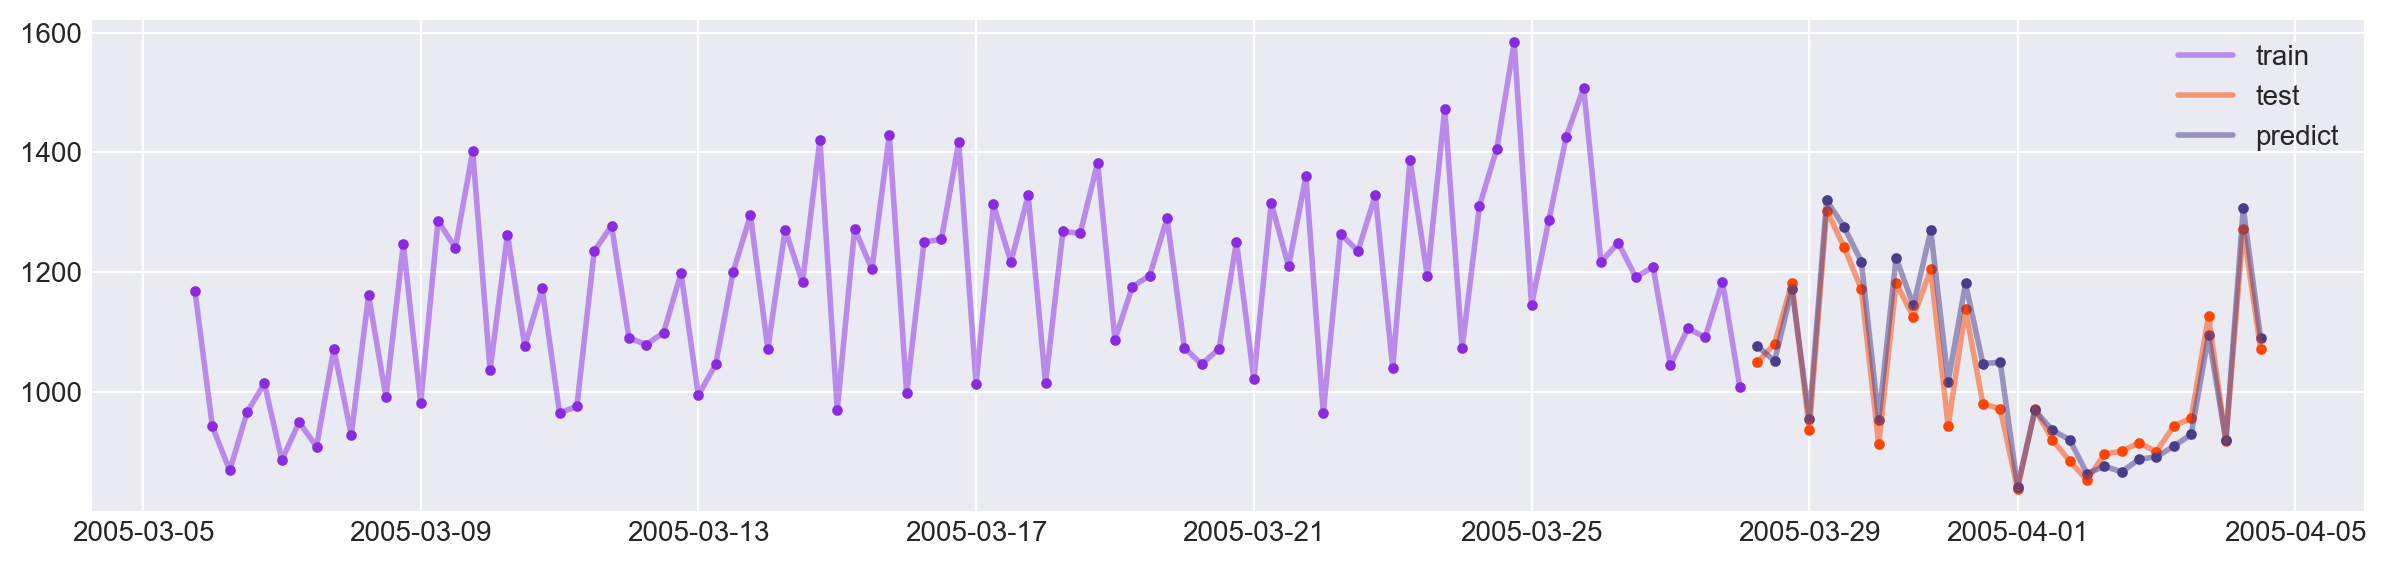

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [21]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 989.0220597	test: 997.8117921	best: 997.8117921 (0)	total: 153ms	remaining: 2m 32s
1:	learn: 898.3850184	test: 906.7282521	best: 906.7282521 (1)	total: 158ms	remaining: 1m 18s
2:	learn: 819.3014491	test: 826.8616753	best: 826.8616753 (2)	total: 167ms	remaining: 55.4s
3:	learn: 744.1613442	test: 767.7051747	best: 767.7051747 (3)	total: 183ms	remaining: 45.6s
4:	learn: 674.8702674	test: 694.2624973	best: 694.2624973 (4)	total: 199ms	remaining: 39.7s
5:	learn: 613.3944100	test: 630.3820732	best: 630.3820732 (5)	total: 215ms	remaining: 35.7s
6:	learn: 558.3018521	test: 579.7665239	best: 579.7665239 (6)	total: 231ms	remaining: 32.7s
7:	learn: 507.3721605	test: 531.7940639	best: 531.7940639 (7)	total: 243ms	remaining: 30.1s
8:	learn: 462.4531213	test: 489.1936836	best: 489.1936836 (8)	total: 256ms	remaining: 28.2s
9:	learn: 420.0824582	test: 447.1566733	best: 447.1566733 (9)	total: 288ms	remaining: 28.5s
10:	learn: 383.2087142	test: 422.0331468	best: 422.0331468 (10)	total: 317ms	r

103:	learn: 40.5573771	test: 72.3282073	best: 72.3282073 (103)	total: 1.79s	remaining: 15.5s
104:	learn: 40.3617170	test: 72.2577205	best: 72.2577205 (104)	total: 1.8s	remaining: 15.3s
105:	learn: 40.1858185	test: 72.2391724	best: 72.2391724 (105)	total: 1.8s	remaining: 15.2s
106:	learn: 39.9549528	test: 72.3512822	best: 72.2391724 (105)	total: 1.8s	remaining: 15.1s
107:	learn: 39.7591100	test: 72.3344306	best: 72.2391724 (105)	total: 1.81s	remaining: 14.9s
108:	learn: 39.5386098	test: 72.1287449	best: 72.1287449 (108)	total: 1.81s	remaining: 14.8s
109:	learn: 39.3204796	test: 71.8043606	best: 71.8043606 (109)	total: 1.82s	remaining: 14.7s
110:	learn: 39.1704079	test: 71.6694360	best: 71.6694360 (110)	total: 1.82s	remaining: 14.6s
111:	learn: 38.9802501	test: 71.6843417	best: 71.6694360 (110)	total: 1.83s	remaining: 14.5s
112:	learn: 38.8020919	test: 71.5270669	best: 71.5270669 (112)	total: 1.83s	remaining: 14.4s
113:	learn: 38.6533449	test: 71.3582323	best: 71.3582323 (113)	total: 1.8

194:	learn: 29.1392150	test: 66.2736219	best: 66.2736219 (194)	total: 3.33s	remaining: 13.7s
195:	learn: 29.0427179	test: 66.3023418	best: 66.2736219 (194)	total: 3.36s	remaining: 13.8s
196:	learn: 28.9543508	test: 66.3074780	best: 66.2736219 (194)	total: 3.38s	remaining: 13.8s
197:	learn: 28.8837374	test: 66.2869199	best: 66.2736219 (194)	total: 3.39s	remaining: 13.7s
198:	learn: 28.8582546	test: 66.2843524	best: 66.2736219 (194)	total: 3.4s	remaining: 13.7s
199:	learn: 28.7683770	test: 66.1692441	best: 66.1692441 (199)	total: 3.42s	remaining: 13.7s
200:	learn: 28.7139400	test: 66.1677766	best: 66.1677766 (200)	total: 3.44s	remaining: 13.7s
201:	learn: 28.6654825	test: 66.1552941	best: 66.1552941 (201)	total: 3.48s	remaining: 13.7s
202:	learn: 28.5892146	test: 66.3095733	best: 66.1552941 (201)	total: 3.51s	remaining: 13.8s
203:	learn: 28.5446847	test: 66.2757952	best: 66.1552941 (201)	total: 3.52s	remaining: 13.8s
204:	learn: 28.4539954	test: 66.2683660	best: 66.1552941 (201)	total: 3

283:	learn: 23.4204355	test: 64.0833382	best: 64.0770498 (282)	total: 4.82s	remaining: 12.2s
284:	learn: 23.3580500	test: 63.9969469	best: 63.9969469 (284)	total: 4.83s	remaining: 12.1s
285:	learn: 23.3053454	test: 63.9544784	best: 63.9544784 (285)	total: 4.83s	remaining: 12.1s
286:	learn: 23.2237405	test: 63.9563460	best: 63.9544784 (285)	total: 4.83s	remaining: 12s
287:	learn: 23.1653296	test: 63.8223528	best: 63.8223528 (287)	total: 4.84s	remaining: 12s
288:	learn: 23.1018994	test: 63.8290248	best: 63.8223528 (287)	total: 4.89s	remaining: 12s
289:	learn: 23.0244387	test: 63.8114358	best: 63.8114358 (289)	total: 4.91s	remaining: 12s
290:	learn: 22.9569226	test: 63.8152158	best: 63.8114358 (289)	total: 4.93s	remaining: 12s
291:	learn: 22.9032740	test: 63.7849332	best: 63.7849332 (291)	total: 4.95s	remaining: 12s
292:	learn: 22.8366537	test: 63.7792015	best: 63.7792015 (292)	total: 4.96s	remaining: 12s
293:	learn: 22.7839451	test: 63.8026790	best: 63.7792015 (292)	total: 4.98s	remainin

376:	learn: 19.2164721	test: 63.0168950	best: 63.0168950 (376)	total: 6.55s	remaining: 10.8s
377:	learn: 19.1686940	test: 62.9790739	best: 62.9790739 (377)	total: 6.56s	remaining: 10.8s
378:	learn: 19.1453407	test: 62.9396256	best: 62.9396256 (378)	total: 6.56s	remaining: 10.8s
379:	learn: 19.1034148	test: 62.8788837	best: 62.8788837 (379)	total: 6.57s	remaining: 10.7s
380:	learn: 19.0765586	test: 62.8776533	best: 62.8776533 (380)	total: 6.57s	remaining: 10.7s
381:	learn: 19.0460877	test: 62.8292273	best: 62.8292273 (381)	total: 6.57s	remaining: 10.6s
382:	learn: 19.0029428	test: 62.8212404	best: 62.8212404 (382)	total: 6.58s	remaining: 10.6s
383:	learn: 18.9712515	test: 62.7849886	best: 62.7849886 (383)	total: 6.58s	remaining: 10.6s
384:	learn: 18.9115345	test: 62.8134764	best: 62.7849886 (383)	total: 6.58s	remaining: 10.5s
385:	learn: 18.8745158	test: 62.7815592	best: 62.7815592 (385)	total: 6.59s	remaining: 10.5s
386:	learn: 18.8386936	test: 62.7767416	best: 62.7767416 (386)	total: 

477:	learn: 15.9150792	test: 62.1362161	best: 62.1362161 (477)	total: 8.04s	remaining: 8.78s
478:	learn: 15.8906446	test: 62.0825023	best: 62.0825023 (478)	total: 8.07s	remaining: 8.78s
479:	learn: 15.8562335	test: 62.0637475	best: 62.0637475 (479)	total: 8.1s	remaining: 8.78s
480:	learn: 15.8283814	test: 62.1684828	best: 62.0637475 (479)	total: 8.13s	remaining: 8.77s
481:	learn: 15.7908312	test: 62.1347958	best: 62.0637475 (479)	total: 8.14s	remaining: 8.75s
482:	learn: 15.7652190	test: 62.1290577	best: 62.0637475 (479)	total: 8.15s	remaining: 8.73s
483:	learn: 15.7315365	test: 62.1195414	best: 62.0637475 (479)	total: 8.17s	remaining: 8.71s
484:	learn: 15.7053745	test: 62.1121688	best: 62.0637475 (479)	total: 8.19s	remaining: 8.69s
485:	learn: 15.6838000	test: 62.0772000	best: 62.0637475 (479)	total: 8.2s	remaining: 8.67s
486:	learn: 15.6652094	test: 62.0860086	best: 62.0637475 (479)	total: 8.21s	remaining: 8.65s
487:	learn: 15.6542654	test: 62.0826343	best: 62.0637475 (479)	total: 8.

567:	learn: 13.4779744	test: 61.7873766	best: 61.7578072 (564)	total: 9.58s	remaining: 7.28s
568:	learn: 13.4476413	test: 61.7592421	best: 61.7578072 (564)	total: 9.58s	remaining: 7.26s
569:	learn: 13.4223593	test: 61.7510311	best: 61.7510311 (569)	total: 9.59s	remaining: 7.24s
570:	learn: 13.4006383	test: 61.7256235	best: 61.7256235 (570)	total: 9.59s	remaining: 7.21s
571:	learn: 13.3891521	test: 61.7268717	best: 61.7256235 (570)	total: 9.6s	remaining: 7.18s
572:	learn: 13.3687026	test: 61.7286535	best: 61.7256235 (570)	total: 9.6s	remaining: 7.16s
573:	learn: 13.3410484	test: 61.7166034	best: 61.7166034 (573)	total: 9.61s	remaining: 7.13s
574:	learn: 13.3167004	test: 61.6292461	best: 61.6292461 (574)	total: 9.61s	remaining: 7.1s
575:	learn: 13.2975187	test: 61.6312618	best: 61.6292461 (574)	total: 9.62s	remaining: 7.08s
576:	learn: 13.2695042	test: 61.6432380	best: 61.6292461 (574)	total: 9.63s	remaining: 7.06s
577:	learn: 13.2540725	test: 61.6490986	best: 61.6292461 (574)	total: 9.6

665:	learn: 11.4423102	test: 61.6965991	best: 61.5657458 (641)	total: 11.1s	remaining: 5.54s
666:	learn: 11.4187790	test: 61.7021099	best: 61.5657458 (641)	total: 11.1s	remaining: 5.52s
667:	learn: 11.3918546	test: 61.6866240	best: 61.5657458 (641)	total: 11.1s	remaining: 5.5s
668:	learn: 11.3718890	test: 61.7390701	best: 61.5657458 (641)	total: 11.1s	remaining: 5.47s
669:	learn: 11.3540696	test: 61.7557775	best: 61.5657458 (641)	total: 11.1s	remaining: 5.45s
670:	learn: 11.3311386	test: 61.7409030	best: 61.5657458 (641)	total: 11.1s	remaining: 5.43s
671:	learn: 11.3277233	test: 61.7359455	best: 61.5657458 (641)	total: 11.1s	remaining: 5.41s
672:	learn: 11.3081637	test: 61.7214323	best: 61.5657458 (641)	total: 11.1s	remaining: 5.4s
673:	learn: 11.2881784	test: 61.7188595	best: 61.5657458 (641)	total: 11.1s	remaining: 5.38s
674:	learn: 11.2675538	test: 61.7403056	best: 61.5657458 (641)	total: 11.2s	remaining: 5.37s
675:	learn: 11.2571673	test: 61.7404014	best: 61.5657458 (641)	total: 11

758:	learn: 9.9204875	test: 61.5778074	best: 61.5457138 (716)	total: 12.4s	remaining: 3.94s
759:	learn: 9.9010947	test: 61.5744401	best: 61.5457138 (716)	total: 12.4s	remaining: 3.92s
760:	learn: 9.8849221	test: 61.5721888	best: 61.5457138 (716)	total: 12.4s	remaining: 3.9s
761:	learn: 9.8784415	test: 61.5665756	best: 61.5457138 (716)	total: 12.4s	remaining: 3.88s
762:	learn: 9.8621114	test: 61.5440840	best: 61.5440840 (762)	total: 12.4s	remaining: 3.87s
763:	learn: 9.8580635	test: 61.5428927	best: 61.5428927 (763)	total: 12.4s	remaining: 3.84s
764:	learn: 9.8431593	test: 61.5405883	best: 61.5405883 (764)	total: 12.4s	remaining: 3.82s
765:	learn: 9.8268834	test: 61.5400505	best: 61.5400505 (765)	total: 12.5s	remaining: 3.81s
766:	learn: 9.8051320	test: 61.5357956	best: 61.5357956 (766)	total: 12.5s	remaining: 3.79s
767:	learn: 9.7875348	test: 61.5349373	best: 61.5349373 (767)	total: 12.5s	remaining: 3.77s
768:	learn: 9.7759772	test: 61.5382560	best: 61.5349373 (767)	total: 12.5s	remain

858:	learn: 8.5818102	test: 61.3790577	best: 61.3674071 (856)	total: 13.9s	remaining: 2.29s
859:	learn: 8.5705113	test: 61.3755388	best: 61.3674071 (856)	total: 13.9s	remaining: 2.27s
860:	learn: 8.5668147	test: 61.3782270	best: 61.3674071 (856)	total: 13.9s	remaining: 2.25s
861:	learn: 8.5477707	test: 61.3850720	best: 61.3674071 (856)	total: 13.9s	remaining: 2.23s
862:	learn: 8.5358540	test: 61.3758413	best: 61.3674071 (856)	total: 14s	remaining: 2.22s
863:	learn: 8.5236658	test: 61.3549183	best: 61.3549183 (863)	total: 14s	remaining: 2.21s
864:	learn: 8.5164316	test: 61.3515671	best: 61.3515671 (864)	total: 14s	remaining: 2.19s
865:	learn: 8.4997281	test: 61.3386017	best: 61.3386017 (865)	total: 14.1s	remaining: 2.17s
866:	learn: 8.4792109	test: 61.3481371	best: 61.3386017 (865)	total: 14.1s	remaining: 2.16s
867:	learn: 8.4738129	test: 61.3478067	best: 61.3386017 (865)	total: 14.1s	remaining: 2.14s
868:	learn: 8.4555428	test: 61.3495671	best: 61.3386017 (865)	total: 14.1s	remaining: 

952:	learn: 7.4795090	test: 61.1597338	best: 61.1565586 (950)	total: 15.6s	remaining: 770ms
953:	learn: 7.4645058	test: 61.1612590	best: 61.1565586 (950)	total: 15.6s	remaining: 754ms
954:	learn: 7.4492993	test: 61.1575559	best: 61.1565586 (950)	total: 15.6s	remaining: 737ms
955:	learn: 7.4378309	test: 61.1569129	best: 61.1565586 (950)	total: 15.7s	remaining: 721ms
956:	learn: 7.4281410	test: 61.1527151	best: 61.1527151 (956)	total: 15.7s	remaining: 704ms
957:	learn: 7.4161003	test: 61.1499686	best: 61.1499686 (957)	total: 15.7s	remaining: 688ms
958:	learn: 7.4042064	test: 61.1466280	best: 61.1466280 (958)	total: 15.7s	remaining: 671ms
959:	learn: 7.3940088	test: 61.1521254	best: 61.1466280 (958)	total: 15.7s	remaining: 655ms
960:	learn: 7.3847244	test: 61.1471481	best: 61.1466280 (958)	total: 15.7s	remaining: 639ms
961:	learn: 7.3774824	test: 61.1568772	best: 61.1466280 (958)	total: 15.8s	remaining: 623ms
962:	learn: 7.3714670	test: 61.1520533	best: 61.1466280 (958)	total: 15.8s	remai

54:	learn: 55.5800970	test: 87.1276204	best: 87.1276204 (54)	total: 1.08s	remaining: 18.6s
55:	learn: 55.1215026	test: 86.1054386	best: 86.1054386 (55)	total: 1.09s	remaining: 18.3s
56:	learn: 54.6404178	test: 85.5838243	best: 85.5838243 (56)	total: 1.09s	remaining: 18s
57:	learn: 54.0043873	test: 85.7170577	best: 85.5838243 (56)	total: 1.09s	remaining: 17.8s
58:	learn: 53.4380020	test: 85.1015091	best: 85.1015091 (58)	total: 1.09s	remaining: 17.5s
59:	learn: 53.0855866	test: 85.0017989	best: 85.0017989 (59)	total: 1.1s	remaining: 17.3s
60:	learn: 52.6206494	test: 84.9567372	best: 84.9567372 (60)	total: 1.12s	remaining: 17.2s
61:	learn: 52.1985407	test: 84.8864110	best: 84.8864110 (61)	total: 1.15s	remaining: 17.4s
62:	learn: 51.7670175	test: 84.2754096	best: 84.2754096 (62)	total: 1.18s	remaining: 17.6s
63:	learn: 51.4312272	test: 84.2218758	best: 84.2218758 (63)	total: 1.2s	remaining: 17.6s
64:	learn: 51.0672909	test: 83.9159065	best: 83.9159065 (64)	total: 1.21s	remaining: 17.5s
65:

151:	learn: 32.8363006	test: 71.5800551	best: 71.4756371 (148)	total: 2.59s	remaining: 14.4s
152:	learn: 32.6761220	test: 71.5453466	best: 71.4756371 (148)	total: 2.61s	remaining: 14.5s
153:	learn: 32.5172660	test: 71.6151949	best: 71.4756371 (148)	total: 2.63s	remaining: 14.5s
154:	learn: 32.4412326	test: 71.6002081	best: 71.4756371 (148)	total: 2.66s	remaining: 14.5s
155:	learn: 32.3805167	test: 71.5787730	best: 71.4756371 (148)	total: 2.68s	remaining: 14.5s
156:	learn: 32.2576400	test: 71.3860054	best: 71.3860054 (156)	total: 2.69s	remaining: 14.5s
157:	learn: 32.1401443	test: 71.2605961	best: 71.2605961 (157)	total: 2.71s	remaining: 14.4s
158:	learn: 32.0006692	test: 70.9143320	best: 70.9143320 (158)	total: 2.74s	remaining: 14.5s
159:	learn: 31.8644218	test: 70.9508440	best: 70.9143320 (158)	total: 2.77s	remaining: 14.6s
160:	learn: 31.7432091	test: 70.8818336	best: 70.8818336 (160)	total: 2.81s	remaining: 14.6s
161:	learn: 31.6070410	test: 70.7798624	best: 70.7798624 (161)	total: 

242:	learn: 25.7298076	test: 67.9552408	best: 67.8709845 (239)	total: 4.36s	remaining: 13.6s
243:	learn: 25.6592922	test: 67.9495279	best: 67.8709845 (239)	total: 4.39s	remaining: 13.6s
244:	learn: 25.6152699	test: 67.6697418	best: 67.6697418 (244)	total: 4.46s	remaining: 13.7s
245:	learn: 25.5572154	test: 67.6783143	best: 67.6697418 (244)	total: 4.49s	remaining: 13.8s
246:	learn: 25.4886074	test: 67.6994871	best: 67.6697418 (244)	total: 4.51s	remaining: 13.7s
247:	learn: 25.4502682	test: 67.7345579	best: 67.6697418 (244)	total: 4.52s	remaining: 13.7s
248:	learn: 25.3764686	test: 67.5192146	best: 67.5192146 (248)	total: 4.55s	remaining: 13.7s
249:	learn: 25.3581730	test: 67.3763590	best: 67.3763590 (249)	total: 4.59s	remaining: 13.8s
250:	learn: 25.2691061	test: 67.3276218	best: 67.3276218 (250)	total: 4.62s	remaining: 13.8s
251:	learn: 25.2220112	test: 67.2499038	best: 67.2499038 (251)	total: 4.64s	remaining: 13.8s
252:	learn: 25.2056021	test: 67.3238293	best: 67.2499038 (251)	total: 

350:	learn: 20.8349549	test: 65.8975372	best: 65.8761011 (349)	total: 6.55s	remaining: 12.1s
351:	learn: 20.7750738	test: 65.9202939	best: 65.8761011 (349)	total: 6.55s	remaining: 12.1s
352:	learn: 20.7237816	test: 65.8850667	best: 65.8761011 (349)	total: 6.55s	remaining: 12s
353:	learn: 20.7148699	test: 65.8869688	best: 65.8761011 (349)	total: 6.56s	remaining: 12s
354:	learn: 20.6847996	test: 65.9101477	best: 65.8761011 (349)	total: 6.56s	remaining: 11.9s
355:	learn: 20.6522897	test: 65.9163251	best: 65.8761011 (349)	total: 6.57s	remaining: 11.9s
356:	learn: 20.6296943	test: 65.7991719	best: 65.7991719 (356)	total: 6.58s	remaining: 11.8s
357:	learn: 20.5905251	test: 65.8323708	best: 65.7991719 (356)	total: 6.63s	remaining: 11.9s
358:	learn: 20.5652839	test: 65.7397279	best: 65.7397279 (358)	total: 6.65s	remaining: 11.9s
359:	learn: 20.5443665	test: 65.7324342	best: 65.7324342 (359)	total: 6.67s	remaining: 11.9s
360:	learn: 20.5003672	test: 65.7482260	best: 65.7324342 (359)	total: 6.69

448:	learn: 17.5140495	test: 65.4170262	best: 65.4170262 (448)	total: 8.46s	remaining: 10.4s
449:	learn: 17.4834327	test: 65.4100441	best: 65.4100441 (449)	total: 8.46s	remaining: 10.3s
450:	learn: 17.4493341	test: 65.2458516	best: 65.2458516 (450)	total: 8.46s	remaining: 10.3s
451:	learn: 17.4146200	test: 65.2056105	best: 65.2056105 (451)	total: 8.47s	remaining: 10.3s
452:	learn: 17.3782312	test: 65.2011203	best: 65.2011203 (452)	total: 8.48s	remaining: 10.2s
453:	learn: 17.3406489	test: 65.3136627	best: 65.2011203 (452)	total: 8.52s	remaining: 10.3s
454:	learn: 17.3111690	test: 65.3090007	best: 65.2011203 (452)	total: 8.55s	remaining: 10.2s
455:	learn: 17.2768919	test: 65.3174112	best: 65.2011203 (452)	total: 8.58s	remaining: 10.2s
456:	learn: 17.2475979	test: 65.2552164	best: 65.2011203 (452)	total: 8.59s	remaining: 10.2s
457:	learn: 17.2236061	test: 65.2620312	best: 65.2011203 (452)	total: 8.6s	remaining: 10.2s
458:	learn: 17.2011771	test: 65.2312206	best: 65.2011203 (452)	total: 8

547:	learn: 15.0004035	test: 64.7271819	best: 64.7271819 (547)	total: 10.4s	remaining: 8.55s
548:	learn: 14.9819775	test: 64.7141614	best: 64.7141614 (548)	total: 10.5s	remaining: 8.59s
549:	learn: 14.9498484	test: 64.6549964	best: 64.6549964 (549)	total: 10.5s	remaining: 8.56s
550:	learn: 14.9027492	test: 64.6172051	best: 64.6172051 (550)	total: 10.5s	remaining: 8.54s
551:	learn: 14.8869886	test: 64.6286899	best: 64.6172051 (550)	total: 10.5s	remaining: 8.51s
552:	learn: 14.8652572	test: 64.6049280	best: 64.6049280 (552)	total: 10.5s	remaining: 8.49s
553:	learn: 14.8425039	test: 64.6391153	best: 64.6049280 (552)	total: 10.5s	remaining: 8.46s
554:	learn: 14.8154678	test: 64.6149563	best: 64.6049280 (552)	total: 10.5s	remaining: 8.44s
555:	learn: 14.7957449	test: 64.6516730	best: 64.6049280 (552)	total: 10.5s	remaining: 8.41s
556:	learn: 14.7808009	test: 64.6679181	best: 64.6049280 (552)	total: 10.6s	remaining: 8.4s
557:	learn: 14.7624528	test: 64.6776874	best: 64.6049280 (552)	total: 1

646:	learn: 12.9114919	test: 64.2797309	best: 64.2152205 (631)	total: 12.2s	remaining: 6.63s
647:	learn: 12.8914408	test: 64.2715619	best: 64.2152205 (631)	total: 12.2s	remaining: 6.61s
648:	learn: 12.8829267	test: 64.2693554	best: 64.2152205 (631)	total: 12.2s	remaining: 6.58s
649:	learn: 12.8618312	test: 64.2790660	best: 64.2152205 (631)	total: 12.2s	remaining: 6.56s
650:	learn: 12.8257087	test: 64.3110885	best: 64.2152205 (631)	total: 12.2s	remaining: 6.54s
651:	learn: 12.8077864	test: 64.3127681	best: 64.2152205 (631)	total: 12.2s	remaining: 6.53s
652:	learn: 12.7755796	test: 64.3325918	best: 64.2152205 (631)	total: 12.3s	remaining: 6.52s
653:	learn: 12.7612891	test: 64.3308179	best: 64.2152205 (631)	total: 12.3s	remaining: 6.5s
654:	learn: 12.7481286	test: 64.3389251	best: 64.2152205 (631)	total: 12.3s	remaining: 6.48s
655:	learn: 12.7336360	test: 64.3280744	best: 64.2152205 (631)	total: 12.3s	remaining: 6.46s
656:	learn: 12.7174874	test: 64.3381185	best: 64.2152205 (631)	total: 1

744:	learn: 11.1731114	test: 64.0507440	best: 64.0507440 (744)	total: 13.9s	remaining: 4.75s
745:	learn: 11.1581997	test: 64.0458873	best: 64.0458873 (745)	total: 13.9s	remaining: 4.73s
746:	learn: 11.1392597	test: 64.0617907	best: 64.0458873 (745)	total: 13.9s	remaining: 4.71s
747:	learn: 11.1278078	test: 64.0638394	best: 64.0458873 (745)	total: 13.9s	remaining: 4.68s
748:	learn: 11.1158140	test: 64.1046602	best: 64.0458873 (745)	total: 13.9s	remaining: 4.66s
749:	learn: 11.0989258	test: 64.1031746	best: 64.0458873 (745)	total: 13.9s	remaining: 4.64s
750:	learn: 11.0871198	test: 64.1247850	best: 64.0458873 (745)	total: 14s	remaining: 4.63s
751:	learn: 11.0641682	test: 64.1229590	best: 64.0458873 (745)	total: 14s	remaining: 4.61s
752:	learn: 11.0478904	test: 64.1030237	best: 64.0458873 (745)	total: 14s	remaining: 4.59s
753:	learn: 11.0378995	test: 64.1060428	best: 64.0458873 (745)	total: 14s	remaining: 4.57s
754:	learn: 11.0205583	test: 64.1265721	best: 64.0458873 (745)	total: 14s	rema

837:	learn: 9.8365500	test: 64.0187089	best: 64.0140329 (836)	total: 15.6s	remaining: 3.01s
838:	learn: 9.8270747	test: 64.0289298	best: 64.0140329 (836)	total: 15.6s	remaining: 2.99s
839:	learn: 9.8154634	test: 64.0208916	best: 64.0140329 (836)	total: 15.6s	remaining: 2.97s
840:	learn: 9.8010832	test: 64.0425847	best: 64.0140329 (836)	total: 15.6s	remaining: 2.95s
841:	learn: 9.7817750	test: 64.0483559	best: 64.0140329 (836)	total: 15.6s	remaining: 2.93s
842:	learn: 9.7709012	test: 64.0507744	best: 64.0140329 (836)	total: 15.7s	remaining: 2.92s
843:	learn: 9.7561681	test: 64.0436976	best: 64.0140329 (836)	total: 15.7s	remaining: 2.9s
844:	learn: 9.7468730	test: 64.0608350	best: 64.0140329 (836)	total: 15.7s	remaining: 2.88s
845:	learn: 9.7355054	test: 64.0371510	best: 64.0140329 (836)	total: 15.7s	remaining: 2.87s
846:	learn: 9.7250384	test: 64.0339198	best: 64.0140329 (836)	total: 15.8s	remaining: 2.85s
847:	learn: 9.7122881	test: 64.0242624	best: 64.0140329 (836)	total: 15.8s	remain

928:	learn: 8.7104013	test: 63.8207539	best: 63.7747309 (896)	total: 17.6s	remaining: 1.34s
929:	learn: 8.6978526	test: 63.8215041	best: 63.7747309 (896)	total: 17.6s	remaining: 1.32s
930:	learn: 8.6849201	test: 63.8020103	best: 63.7747309 (896)	total: 17.6s	remaining: 1.3s
931:	learn: 8.6778001	test: 63.8040514	best: 63.7747309 (896)	total: 17.6s	remaining: 1.28s
932:	learn: 8.6673998	test: 63.8093555	best: 63.7747309 (896)	total: 17.6s	remaining: 1.26s
933:	learn: 8.6555346	test: 63.8154271	best: 63.7747309 (896)	total: 17.6s	remaining: 1.25s
934:	learn: 8.6487808	test: 63.8058352	best: 63.7747309 (896)	total: 17.6s	remaining: 1.23s
935:	learn: 8.6371927	test: 63.8094384	best: 63.7747309 (896)	total: 17.7s	remaining: 1.21s
936:	learn: 8.6294949	test: 63.8307597	best: 63.7747309 (896)	total: 17.7s	remaining: 1.19s
937:	learn: 8.6186129	test: 63.8118343	best: 63.7747309 (896)	total: 17.7s	remaining: 1.17s
938:	learn: 8.6076581	test: 63.8181079	best: 63.7747309 (896)	total: 17.8s	remain

25:	learn: 108.2510910	test: 142.3445402	best: 142.3445402 (25)	total: 548ms	remaining: 20.5s
26:	learn: 102.3457293	test: 136.2001769	best: 136.2001769 (26)	total: 569ms	remaining: 20.5s
27:	learn: 96.5121491	test: 130.7087061	best: 130.7087061 (27)	total: 590ms	remaining: 20.5s
28:	learn: 91.3512199	test: 124.7869734	best: 124.7869734 (28)	total: 605ms	remaining: 20.2s
29:	learn: 86.9261132	test: 120.4978405	best: 120.4978405 (29)	total: 617ms	remaining: 20s
30:	learn: 82.6951750	test: 117.0349428	best: 117.0349428 (30)	total: 645ms	remaining: 20.2s
31:	learn: 79.3707184	test: 114.1058574	best: 114.1058574 (31)	total: 669ms	remaining: 20.2s
32:	learn: 76.1360306	test: 110.9244451	best: 110.9244451 (32)	total: 693ms	remaining: 20.3s
33:	learn: 73.6219096	test: 108.0700151	best: 108.0700151 (33)	total: 715ms	remaining: 20.3s
34:	learn: 70.8354387	test: 106.2790138	best: 106.2790138 (34)	total: 728ms	remaining: 20.1s
35:	learn: 68.6304178	test: 104.1623819	best: 104.1623819 (35)	total: 

129:	learn: 32.0596479	test: 85.0958012	best: 85.0522930 (126)	total: 2.3s	remaining: 15.4s
130:	learn: 31.9215945	test: 85.0759097	best: 85.0522930 (126)	total: 2.32s	remaining: 15.4s
131:	learn: 31.8061383	test: 84.5968965	best: 84.5968965 (131)	total: 2.35s	remaining: 15.4s
132:	learn: 31.5731752	test: 84.4088267	best: 84.4088267 (132)	total: 2.37s	remaining: 15.5s
133:	learn: 31.4617225	test: 84.3542839	best: 84.3542839 (133)	total: 2.38s	remaining: 15.4s
134:	learn: 31.3383925	test: 84.3435800	best: 84.3435800 (134)	total: 2.4s	remaining: 15.4s
135:	learn: 31.1534981	test: 84.2102542	best: 84.2102542 (135)	total: 2.42s	remaining: 15.4s
136:	learn: 31.0372741	test: 84.2695027	best: 84.2102542 (135)	total: 2.43s	remaining: 15.3s
137:	learn: 30.9110143	test: 84.1414630	best: 84.1414630 (137)	total: 2.44s	remaining: 15.3s
138:	learn: 30.7727126	test: 84.1017696	best: 84.1017696 (138)	total: 2.49s	remaining: 15.4s
139:	learn: 30.6266526	test: 83.9350232	best: 83.9350232 (139)	total: 2.

220:	learn: 22.9107278	test: 82.9619852	best: 82.9619852 (220)	total: 3.59s	remaining: 12.6s
221:	learn: 22.8389484	test: 82.9781072	best: 82.9619852 (220)	total: 3.59s	remaining: 12.6s
222:	learn: 22.7743985	test: 82.9657888	best: 82.9619852 (220)	total: 3.59s	remaining: 12.5s
223:	learn: 22.6778535	test: 82.9593725	best: 82.9593725 (223)	total: 3.6s	remaining: 12.5s
224:	learn: 22.6150671	test: 82.8707256	best: 82.8707256 (224)	total: 3.6s	remaining: 12.4s
225:	learn: 22.5525340	test: 82.8178531	best: 82.8178531 (225)	total: 3.6s	remaining: 12.3s
226:	learn: 22.4937474	test: 82.8161350	best: 82.8161350 (226)	total: 3.6s	remaining: 12.3s
227:	learn: 22.4232557	test: 82.8645902	best: 82.8161350 (226)	total: 3.61s	remaining: 12.2s
228:	learn: 22.3641756	test: 82.9174839	best: 82.8161350 (226)	total: 3.61s	remaining: 12.2s
229:	learn: 22.2726092	test: 82.9308102	best: 82.8161350 (226)	total: 3.62s	remaining: 12.1s
230:	learn: 22.2105182	test: 82.8713712	best: 82.8161350 (226)	total: 3.62

315:	learn: 17.7238335	test: 82.8106075	best: 82.8056513 (313)	total: 5.29s	remaining: 11.4s
316:	learn: 17.7016482	test: 82.8345172	best: 82.8056513 (313)	total: 5.31s	remaining: 11.4s
317:	learn: 17.6449941	test: 82.8369797	best: 82.8056513 (313)	total: 5.33s	remaining: 11.4s
318:	learn: 17.6042144	test: 82.8778876	best: 82.8056513 (313)	total: 5.35s	remaining: 11.4s
319:	learn: 17.5756350	test: 82.9081447	best: 82.8056513 (313)	total: 5.36s	remaining: 11.4s
320:	learn: 17.5416777	test: 82.8855187	best: 82.8056513 (313)	total: 5.38s	remaining: 11.4s
321:	learn: 17.5073495	test: 82.8913928	best: 82.8056513 (313)	total: 5.39s	remaining: 11.3s
322:	learn: 17.4720397	test: 83.0816843	best: 82.8056513 (313)	total: 5.4s	remaining: 11.3s
323:	learn: 17.4453576	test: 83.1351149	best: 82.8056513 (313)	total: 5.43s	remaining: 11.3s
324:	learn: 17.4166351	test: 83.1348698	best: 82.8056513 (313)	total: 5.47s	remaining: 11.4s
325:	learn: 17.3634382	test: 83.1528885	best: 82.8056513 (313)	total: 5

406:	learn: 14.5686085	test: 82.4509786	best: 82.3300732 (388)	total: 7s	remaining: 10.2s
407:	learn: 14.5240749	test: 82.4491786	best: 82.3300732 (388)	total: 7.04s	remaining: 10.2s
408:	learn: 14.4863982	test: 82.4601874	best: 82.3300732 (388)	total: 7.05s	remaining: 10.2s
409:	learn: 14.4635525	test: 82.4409116	best: 82.3300732 (388)	total: 7.07s	remaining: 10.2s
410:	learn: 14.4360617	test: 82.4465212	best: 82.3300732 (388)	total: 7.08s	remaining: 10.2s
411:	learn: 14.4196300	test: 82.4526411	best: 82.3300732 (388)	total: 7.1s	remaining: 10.1s
412:	learn: 14.3984155	test: 82.4320831	best: 82.3300732 (388)	total: 7.11s	remaining: 10.1s
413:	learn: 14.3880505	test: 82.4281847	best: 82.3300732 (388)	total: 7.13s	remaining: 10.1s
414:	learn: 14.3489362	test: 82.4043749	best: 82.3300732 (388)	total: 7.15s	remaining: 10.1s
415:	learn: 14.3198167	test: 82.3848342	best: 82.3300732 (388)	total: 7.23s	remaining: 10.2s
416:	learn: 14.3083710	test: 82.3560279	best: 82.3300732 (388)	total: 7.25

507:	learn: 12.1028449	test: 82.1292666	best: 82.1026398 (502)	total: 8.49s	remaining: 8.22s
508:	learn: 12.0837367	test: 82.1209864	best: 82.1026398 (502)	total: 8.49s	remaining: 8.19s
509:	learn: 12.0725574	test: 82.0997274	best: 82.0997274 (509)	total: 8.5s	remaining: 8.16s
510:	learn: 12.0580769	test: 82.1522716	best: 82.0997274 (509)	total: 8.5s	remaining: 8.14s
511:	learn: 12.0316510	test: 82.1551439	best: 82.0997274 (509)	total: 8.51s	remaining: 8.11s
512:	learn: 12.0031588	test: 82.1815496	best: 82.0997274 (509)	total: 8.51s	remaining: 8.08s
513:	learn: 11.9914882	test: 82.1748933	best: 82.0997274 (509)	total: 8.52s	remaining: 8.05s
514:	learn: 11.9696840	test: 82.0868995	best: 82.0868995 (514)	total: 8.53s	remaining: 8.03s
515:	learn: 11.9469778	test: 82.1015681	best: 82.0868995 (514)	total: 8.54s	remaining: 8.01s
516:	learn: 11.9255488	test: 82.1053864	best: 82.0868995 (514)	total: 8.55s	remaining: 7.99s
517:	learn: 11.9127998	test: 82.0990409	best: 82.0868995 (514)	total: 8.

605:	learn: 10.2382471	test: 82.1030797	best: 81.9995103 (558)	total: 9.97s	remaining: 6.48s
606:	learn: 10.2197613	test: 82.1215032	best: 81.9995103 (558)	total: 9.97s	remaining: 6.46s
607:	learn: 10.2030434	test: 82.1041890	best: 81.9995103 (558)	total: 9.97s	remaining: 6.43s
608:	learn: 10.1893571	test: 82.1050542	best: 81.9995103 (558)	total: 9.98s	remaining: 6.41s
609:	learn: 10.1774613	test: 82.0971188	best: 81.9995103 (558)	total: 9.98s	remaining: 6.38s
610:	learn: 10.1539685	test: 82.0806017	best: 81.9995103 (558)	total: 9.98s	remaining: 6.36s
611:	learn: 10.1451903	test: 82.0681790	best: 81.9995103 (558)	total: 9.99s	remaining: 6.33s
612:	learn: 10.1337039	test: 82.0731421	best: 81.9995103 (558)	total: 9.99s	remaining: 6.31s
613:	learn: 10.1098849	test: 82.0796843	best: 81.9995103 (558)	total: 10s	remaining: 6.29s
614:	learn: 10.1008824	test: 82.0906499	best: 81.9995103 (558)	total: 10.1s	remaining: 6.29s
615:	learn: 10.0878877	test: 82.0953465	best: 81.9995103 (558)	total: 10

702:	learn: 8.7251503	test: 82.1657306	best: 81.9995103 (558)	total: 11.7s	remaining: 4.94s
703:	learn: 8.7010998	test: 82.1655379	best: 81.9995103 (558)	total: 11.7s	remaining: 4.92s
704:	learn: 8.6873182	test: 82.1655188	best: 81.9995103 (558)	total: 11.7s	remaining: 4.9s
705:	learn: 8.6698415	test: 82.1672806	best: 81.9995103 (558)	total: 11.7s	remaining: 4.88s
706:	learn: 8.6598208	test: 82.1768590	best: 81.9995103 (558)	total: 11.7s	remaining: 4.86s
707:	learn: 8.6351715	test: 82.1900687	best: 81.9995103 (558)	total: 11.7s	remaining: 4.83s
708:	learn: 8.6326761	test: 82.1910008	best: 81.9995103 (558)	total: 11.7s	remaining: 4.82s
709:	learn: 8.6136369	test: 82.1670667	best: 81.9995103 (558)	total: 11.8s	remaining: 4.81s
710:	learn: 8.5965860	test: 82.1698261	best: 81.9995103 (558)	total: 11.8s	remaining: 4.8s
711:	learn: 8.5856427	test: 82.1684057	best: 81.9995103 (558)	total: 11.8s	remaining: 4.78s
712:	learn: 8.5667577	test: 82.2234657	best: 81.9995103 (558)	total: 11.8s	remaini

795:	learn: 7.4664368	test: 82.1083025	best: 81.9114603 (764)	total: 13.4s	remaining: 3.43s
796:	learn: 7.4548693	test: 82.1149787	best: 81.9114603 (764)	total: 13.4s	remaining: 3.42s
797:	learn: 7.4370654	test: 82.1342701	best: 81.9114603 (764)	total: 13.5s	remaining: 3.4s
798:	learn: 7.4237663	test: 82.1364801	best: 81.9114603 (764)	total: 13.5s	remaining: 3.39s
799:	learn: 7.4128454	test: 82.1547023	best: 81.9114603 (764)	total: 13.5s	remaining: 3.37s
800:	learn: 7.4051722	test: 82.1511076	best: 81.9114603 (764)	total: 13.5s	remaining: 3.35s
801:	learn: 7.3971840	test: 82.1510888	best: 81.9114603 (764)	total: 13.5s	remaining: 3.34s
802:	learn: 7.3850388	test: 82.1516525	best: 81.9114603 (764)	total: 13.5s	remaining: 3.32s
803:	learn: 7.3721788	test: 82.1270230	best: 81.9114603 (764)	total: 13.6s	remaining: 3.31s
804:	learn: 7.3613557	test: 82.1259261	best: 81.9114603 (764)	total: 13.6s	remaining: 3.3s
805:	learn: 7.3512901	test: 82.1418251	best: 81.9114603 (764)	total: 13.6s	remaini

885:	learn: 6.5349925	test: 82.3486424	best: 81.9114603 (764)	total: 15.1s	remaining: 1.95s
886:	learn: 6.5237312	test: 82.3546260	best: 81.9114603 (764)	total: 15.2s	remaining: 1.93s
887:	learn: 6.5125895	test: 82.3540933	best: 81.9114603 (764)	total: 15.2s	remaining: 1.91s
888:	learn: 6.5084455	test: 82.3538450	best: 81.9114603 (764)	total: 15.2s	remaining: 1.9s
889:	learn: 6.4927545	test: 82.3779234	best: 81.9114603 (764)	total: 15.2s	remaining: 1.88s
890:	learn: 6.4880243	test: 82.3715419	best: 81.9114603 (764)	total: 15.3s	remaining: 1.86s
891:	learn: 6.4731756	test: 82.3727143	best: 81.9114603 (764)	total: 15.3s	remaining: 1.85s
892:	learn: 6.4530607	test: 82.3768617	best: 81.9114603 (764)	total: 15.3s	remaining: 1.84s
893:	learn: 6.4491580	test: 82.3769429	best: 81.9114603 (764)	total: 15.3s	remaining: 1.82s
894:	learn: 6.4398820	test: 82.3713847	best: 81.9114603 (764)	total: 15.4s	remaining: 1.8s
895:	learn: 6.4336417	test: 82.3746442	best: 81.9114603 (764)	total: 15.4s	remaini

983:	learn: 5.6260211	test: 82.6866543	best: 81.9114603 (764)	total: 17.1s	remaining: 278ms
984:	learn: 5.6181974	test: 82.6957017	best: 81.9114603 (764)	total: 17.1s	remaining: 260ms
985:	learn: 5.6121202	test: 82.6969559	best: 81.9114603 (764)	total: 17.1s	remaining: 243ms
986:	learn: 5.6022370	test: 82.6983568	best: 81.9114603 (764)	total: 17.1s	remaining: 225ms
987:	learn: 5.5945545	test: 82.6881332	best: 81.9114603 (764)	total: 17.1s	remaining: 208ms
988:	learn: 5.5864095	test: 82.6892985	best: 81.9114603 (764)	total: 17.1s	remaining: 190ms
989:	learn: 5.5833908	test: 82.6892249	best: 81.9114603 (764)	total: 17.1s	remaining: 173ms
990:	learn: 5.5773659	test: 82.6954739	best: 81.9114603 (764)	total: 17.1s	remaining: 156ms
991:	learn: 5.5714732	test: 82.6972334	best: 81.9114603 (764)	total: 17.2s	remaining: 138ms
992:	learn: 5.5617176	test: 82.6994301	best: 81.9114603 (764)	total: 17.2s	remaining: 121ms
993:	learn: 5.5597608	test: 82.7090878	best: 81.9114603 (764)	total: 17.2s	remai

74:	learn: 46.8436192	test: 65.1355967	best: 65.1355967 (74)	total: 1.33s	remaining: 16.4s
75:	learn: 46.6295154	test: 65.0674937	best: 65.0674937 (75)	total: 1.35s	remaining: 16.4s
76:	learn: 46.3112673	test: 65.0335562	best: 65.0335562 (76)	total: 1.37s	remaining: 16.4s
77:	learn: 45.9808872	test: 64.7896077	best: 64.7896077 (77)	total: 1.38s	remaining: 16.3s
78:	learn: 45.7584814	test: 64.5919548	best: 64.5919548 (78)	total: 1.39s	remaining: 16.2s
79:	learn: 45.3774564	test: 64.3833960	best: 64.3833960 (79)	total: 1.41s	remaining: 16.2s
80:	learn: 45.0985183	test: 64.2979126	best: 64.2979126 (80)	total: 1.42s	remaining: 16.1s
81:	learn: 44.9100056	test: 64.2256680	best: 64.2256680 (81)	total: 1.43s	remaining: 16s
82:	learn: 44.6463912	test: 64.1104681	best: 64.1104681 (82)	total: 1.45s	remaining: 16s
83:	learn: 44.3490691	test: 63.8654789	best: 63.8654789 (83)	total: 1.48s	remaining: 16.1s
84:	learn: 44.0363615	test: 63.7644645	best: 63.7644645 (84)	total: 1.5s	remaining: 16.2s
85:	

169:	learn: 30.1371770	test: 56.2177098	best: 56.1921522 (168)	total: 2.85s	remaining: 13.9s
170:	learn: 30.0330759	test: 56.2064230	best: 56.1921522 (168)	total: 2.85s	remaining: 13.8s
171:	learn: 29.9626469	test: 56.2430094	best: 56.1921522 (168)	total: 2.86s	remaining: 13.8s
172:	learn: 29.8671290	test: 56.2521085	best: 56.1921522 (168)	total: 2.87s	remaining: 13.7s
173:	learn: 29.7421383	test: 56.2621343	best: 56.1921522 (168)	total: 2.91s	remaining: 13.8s
174:	learn: 29.6171317	test: 56.1770854	best: 56.1770854 (174)	total: 2.94s	remaining: 13.9s
175:	learn: 29.4910761	test: 56.1105379	best: 56.1105379 (175)	total: 2.96s	remaining: 13.9s
176:	learn: 29.3727810	test: 56.1008918	best: 56.1008918 (176)	total: 2.98s	remaining: 13.9s
177:	learn: 29.2501937	test: 55.9612953	best: 55.9612953 (177)	total: 3s	remaining: 13.8s
178:	learn: 29.1429721	test: 56.0007771	best: 55.9612953 (177)	total: 3.01s	remaining: 13.8s
179:	learn: 29.0587623	test: 56.0582641	best: 55.9612953 (177)	total: 3.0

264:	learn: 22.2029198	test: 54.0291213	best: 53.9744679 (262)	total: 4.56s	remaining: 12.6s
265:	learn: 22.1364232	test: 53.9797504	best: 53.9744679 (262)	total: 4.59s	remaining: 12.7s
266:	learn: 22.0684800	test: 53.9653213	best: 53.9653213 (266)	total: 4.61s	remaining: 12.7s
267:	learn: 22.0000208	test: 53.9408375	best: 53.9408375 (267)	total: 4.64s	remaining: 12.7s
268:	learn: 21.9424044	test: 53.9037864	best: 53.9037864 (268)	total: 4.65s	remaining: 12.6s
269:	learn: 21.8768758	test: 53.9237486	best: 53.9037864 (268)	total: 4.66s	remaining: 12.6s
270:	learn: 21.8200905	test: 53.6124741	best: 53.6124741 (270)	total: 4.67s	remaining: 12.6s
271:	learn: 21.7781402	test: 53.5982904	best: 53.5982904 (271)	total: 4.68s	remaining: 12.5s
272:	learn: 21.7164983	test: 53.5912385	best: 53.5912385 (272)	total: 4.69s	remaining: 12.5s
273:	learn: 21.6262193	test: 53.5330544	best: 53.5330544 (273)	total: 4.72s	remaining: 12.5s
274:	learn: 21.5812943	test: 53.4619214	best: 53.4619214 (274)	total: 

355:	learn: 17.5350961	test: 52.1813801	best: 52.1813801 (355)	total: 6.54s	remaining: 11.8s
356:	learn: 17.5242324	test: 52.1812656	best: 52.1812656 (356)	total: 6.56s	remaining: 11.8s
357:	learn: 17.4787447	test: 52.2033674	best: 52.1812656 (356)	total: 6.58s	remaining: 11.8s
358:	learn: 17.4373134	test: 52.2020840	best: 52.1812656 (356)	total: 6.6s	remaining: 11.8s
359:	learn: 17.3963926	test: 52.1954274	best: 52.1812656 (356)	total: 6.61s	remaining: 11.8s
360:	learn: 17.3573638	test: 52.2072111	best: 52.1812656 (356)	total: 6.63s	remaining: 11.7s
361:	learn: 17.3107153	test: 52.1831569	best: 52.1812656 (356)	total: 6.65s	remaining: 11.7s
362:	learn: 17.2708411	test: 52.1333556	best: 52.1333556 (362)	total: 6.72s	remaining: 11.8s
363:	learn: 17.2336457	test: 52.1337211	best: 52.1333556 (362)	total: 6.74s	remaining: 11.8s
364:	learn: 17.1829235	test: 52.1534001	best: 52.1333556 (362)	total: 6.75s	remaining: 11.7s
365:	learn: 17.1277950	test: 52.1616020	best: 52.1333556 (362)	total: 6

447:	learn: 14.4049699	test: 51.3656076	best: 51.3656076 (447)	total: 8.21s	remaining: 10.1s
448:	learn: 14.3612896	test: 51.3664517	best: 51.3656076 (447)	total: 8.24s	remaining: 10.1s
449:	learn: 14.3230557	test: 51.3695885	best: 51.3656076 (447)	total: 8.26s	remaining: 10.1s
450:	learn: 14.3024201	test: 51.3686062	best: 51.3656076 (447)	total: 8.28s	remaining: 10.1s
451:	learn: 14.2641496	test: 51.3666475	best: 51.3656076 (447)	total: 8.29s	remaining: 10.1s
452:	learn: 14.2313170	test: 51.3553052	best: 51.3553052 (452)	total: 8.31s	remaining: 10s
453:	learn: 14.2264552	test: 51.3666102	best: 51.3553052 (452)	total: 8.34s	remaining: 10s
454:	learn: 14.2104303	test: 51.3803749	best: 51.3553052 (452)	total: 8.37s	remaining: 10s
455:	learn: 14.1921909	test: 51.3734950	best: 51.3553052 (452)	total: 8.4s	remaining: 10s
456:	learn: 14.1616459	test: 51.3624530	best: 51.3553052 (452)	total: 8.42s	remaining: 10s
457:	learn: 14.1556543	test: 51.3621753	best: 51.3553052 (452)	total: 8.43s	remai

540:	learn: 12.1354615	test: 51.2620711	best: 51.1243851 (516)	total: 9.96s	remaining: 8.45s
541:	learn: 12.1117461	test: 51.2554414	best: 51.1243851 (516)	total: 9.96s	remaining: 8.42s
542:	learn: 12.0959682	test: 51.2565516	best: 51.1243851 (516)	total: 9.97s	remaining: 8.39s
543:	learn: 12.0602183	test: 51.2557932	best: 51.1243851 (516)	total: 9.98s	remaining: 8.36s
544:	learn: 12.0421028	test: 51.2482069	best: 51.1243851 (516)	total: 10s	remaining: 8.35s
545:	learn: 12.0196308	test: 51.2242359	best: 51.1243851 (516)	total: 10s	remaining: 8.34s
546:	learn: 11.9932534	test: 51.1427142	best: 51.1243851 (516)	total: 10s	remaining: 8.32s
547:	learn: 11.9667099	test: 51.1485419	best: 51.1243851 (516)	total: 10.1s	remaining: 8.3s
548:	learn: 11.9427337	test: 51.1505064	best: 51.1243851 (516)	total: 10.1s	remaining: 8.27s
549:	learn: 11.9306730	test: 51.1565177	best: 51.1243851 (516)	total: 10.1s	remaining: 8.25s
550:	learn: 11.9121642	test: 51.1518471	best: 51.1243851 (516)	total: 10.1s	r

635:	learn: 10.2815672	test: 51.0784126	best: 51.0784126 (635)	total: 11.7s	remaining: 6.68s
636:	learn: 10.2643031	test: 51.0577180	best: 51.0577180 (636)	total: 11.7s	remaining: 6.66s
637:	learn: 10.2454548	test: 51.0666490	best: 51.0577180 (636)	total: 11.7s	remaining: 6.63s
638:	learn: 10.2257791	test: 51.0230054	best: 51.0230054 (638)	total: 11.7s	remaining: 6.6s
639:	learn: 10.2122171	test: 51.0246239	best: 51.0230054 (638)	total: 11.7s	remaining: 6.58s
640:	learn: 10.1977602	test: 51.0071790	best: 51.0071790 (640)	total: 11.7s	remaining: 6.56s
641:	learn: 10.1781820	test: 50.9773031	best: 50.9773031 (641)	total: 11.7s	remaining: 6.54s
642:	learn: 10.1634920	test: 50.9731065	best: 50.9731065 (642)	total: 11.8s	remaining: 6.53s
643:	learn: 10.1388471	test: 50.9769866	best: 50.9731065 (642)	total: 11.8s	remaining: 6.52s
644:	learn: 10.1205735	test: 50.9685886	best: 50.9685886 (644)	total: 11.8s	remaining: 6.5s
645:	learn: 10.1079669	test: 50.9696593	best: 50.9685886 (644)	total: 11

726:	learn: 8.8594230	test: 50.9269855	best: 50.9188261 (703)	total: 13.4s	remaining: 5.03s
727:	learn: 8.8552488	test: 50.9266211	best: 50.9188261 (703)	total: 13.4s	remaining: 5.01s
728:	learn: 8.8379689	test: 50.9200927	best: 50.9188261 (703)	total: 13.4s	remaining: 4.99s
729:	learn: 8.8374578	test: 50.9241800	best: 50.9188261 (703)	total: 13.4s	remaining: 4.97s
730:	learn: 8.8171846	test: 50.9089380	best: 50.9089380 (730)	total: 13.5s	remaining: 4.95s
731:	learn: 8.7960809	test: 50.9030399	best: 50.9030399 (731)	total: 13.5s	remaining: 4.93s
732:	learn: 8.7816242	test: 50.8929830	best: 50.8929830 (732)	total: 13.5s	remaining: 4.92s
733:	learn: 8.7649323	test: 50.8860541	best: 50.8860541 (733)	total: 13.5s	remaining: 4.9s
734:	learn: 8.7526722	test: 50.8874874	best: 50.8860541 (733)	total: 13.6s	remaining: 4.88s
735:	learn: 8.7321737	test: 50.8678181	best: 50.8678181 (735)	total: 13.6s	remaining: 4.86s
736:	learn: 8.7154231	test: 50.8657896	best: 50.8657896 (736)	total: 13.6s	remain

828:	learn: 7.4578266	test: 50.7294452	best: 50.6974050 (803)	total: 15.3s	remaining: 3.16s
829:	learn: 7.4479150	test: 50.7304105	best: 50.6974050 (803)	total: 15.4s	remaining: 3.14s
830:	learn: 7.4343467	test: 50.7626807	best: 50.6974050 (803)	total: 15.4s	remaining: 3.13s
831:	learn: 7.4187752	test: 50.7504424	best: 50.6974050 (803)	total: 15.4s	remaining: 3.11s
832:	learn: 7.4102712	test: 50.7468740	best: 50.6974050 (803)	total: 15.4s	remaining: 3.09s
833:	learn: 7.3974750	test: 50.7392007	best: 50.6974050 (803)	total: 15.4s	remaining: 3.07s
834:	learn: 7.3872981	test: 50.7391732	best: 50.6974050 (803)	total: 15.4s	remaining: 3.05s
835:	learn: 7.3798057	test: 50.7464215	best: 50.6974050 (803)	total: 15.5s	remaining: 3.03s
836:	learn: 7.3691421	test: 50.7455286	best: 50.6974050 (803)	total: 15.5s	remaining: 3.01s
837:	learn: 7.3640860	test: 50.7454629	best: 50.6974050 (803)	total: 15.5s	remaining: 3s
838:	learn: 7.3552086	test: 50.7479214	best: 50.6974050 (803)	total: 15.5s	remainin

927:	learn: 6.3862427	test: 50.6834172	best: 50.6628151 (909)	total: 17.3s	remaining: 1.34s
928:	learn: 6.3814221	test: 50.6729087	best: 50.6628151 (909)	total: 17.3s	remaining: 1.32s
929:	learn: 6.3703020	test: 50.6641723	best: 50.6628151 (909)	total: 17.3s	remaining: 1.3s
930:	learn: 6.3614232	test: 50.6662825	best: 50.6628151 (909)	total: 17.3s	remaining: 1.28s
931:	learn: 6.3499423	test: 50.6646531	best: 50.6628151 (909)	total: 17.3s	remaining: 1.26s
932:	learn: 6.3340307	test: 50.6557808	best: 50.6557808 (932)	total: 17.3s	remaining: 1.25s
933:	learn: 6.3234172	test: 50.6482192	best: 50.6482192 (933)	total: 17.4s	remaining: 1.23s
934:	learn: 6.3153951	test: 50.6479522	best: 50.6479522 (934)	total: 17.4s	remaining: 1.21s
935:	learn: 6.3088069	test: 50.6437603	best: 50.6437603 (935)	total: 17.4s	remaining: 1.19s
936:	learn: 6.3004804	test: 50.6454520	best: 50.6437603 (935)	total: 17.4s	remaining: 1.17s
937:	learn: 6.2876741	test: 50.6509379	best: 50.6437603 (935)	total: 17.4s	remain

17:	learn: 199.9626250	test: 303.5803909	best: 303.5803909 (17)	total: 360ms	remaining: 19.6s
18:	learn: 183.1003482	test: 291.2532764	best: 291.2532764 (18)	total: 376ms	remaining: 19.4s
19:	learn: 168.2516736	test: 275.9074480	best: 275.9074480 (19)	total: 384ms	remaining: 18.8s
20:	learn: 155.5065785	test: 263.9587617	best: 263.9587617 (20)	total: 391ms	remaining: 18.2s
21:	learn: 143.8292528	test: 251.2913658	best: 251.2913658 (21)	total: 455ms	remaining: 20.2s
22:	learn: 133.4184660	test: 241.6572504	best: 241.6572504 (22)	total: 486ms	remaining: 20.6s
23:	learn: 123.6204199	test: 229.0060356	best: 229.0060356 (23)	total: 506ms	remaining: 20.6s
24:	learn: 115.1703513	test: 221.7509561	best: 221.7509561 (24)	total: 520ms	remaining: 20.3s
25:	learn: 107.5373787	test: 212.1280228	best: 212.1280228 (25)	total: 534ms	remaining: 20s
26:	learn: 100.3338062	test: 205.8962993	best: 205.8962993 (26)	total: 551ms	remaining: 19.9s
27:	learn: 94.2739304	test: 200.2273786	best: 200.2273786 (27)

123:	learn: 33.1116989	test: 116.7329423	best: 116.5468441 (98)	total: 2.26s	remaining: 16s
124:	learn: 32.9491979	test: 116.4594081	best: 116.4594081 (124)	total: 2.29s	remaining: 16.1s
125:	learn: 32.8018877	test: 115.6446005	best: 115.6446005 (125)	total: 2.32s	remaining: 16.1s
126:	learn: 32.7142422	test: 115.0850835	best: 115.0850835 (126)	total: 2.34s	remaining: 16.1s
127:	learn: 32.5757655	test: 115.0000306	best: 115.0000306 (127)	total: 2.35s	remaining: 16s
128:	learn: 32.3802022	test: 115.0534984	best: 115.0000306 (127)	total: 2.37s	remaining: 16s
129:	learn: 32.2852394	test: 115.2391415	best: 115.0000306 (127)	total: 2.38s	remaining: 16s
130:	learn: 32.2133267	test: 115.3282085	best: 115.0000306 (127)	total: 2.4s	remaining: 15.9s
131:	learn: 32.0742771	test: 114.7381741	best: 114.7381741 (131)	total: 2.41s	remaining: 15.9s
132:	learn: 31.9402291	test: 114.7095260	best: 114.7095260 (132)	total: 2.44s	remaining: 15.9s
133:	learn: 31.7684489	test: 114.8415898	best: 114.7095260 (

211:	learn: 24.5586233	test: 109.6870691	best: 109.6124507 (209)	total: 3.78s	remaining: 14s
212:	learn: 24.4629775	test: 109.6922316	best: 109.6124507 (209)	total: 3.8s	remaining: 14s
213:	learn: 24.3904280	test: 109.7476304	best: 109.6124507 (209)	total: 3.81s	remaining: 14s
214:	learn: 24.3126946	test: 109.6701574	best: 109.6124507 (209)	total: 3.84s	remaining: 14s
215:	learn: 24.2330030	test: 109.6537077	best: 109.6124507 (209)	total: 3.87s	remaining: 14.1s
216:	learn: 24.1445076	test: 109.4777122	best: 109.4777122 (216)	total: 3.9s	remaining: 14.1s
217:	learn: 24.1120552	test: 109.3974861	best: 109.3974861 (217)	total: 3.92s	remaining: 14.1s
218:	learn: 24.0177712	test: 109.2100309	best: 109.2100309 (218)	total: 3.94s	remaining: 14s
219:	learn: 23.9461089	test: 109.1539114	best: 109.1539114 (219)	total: 3.95s	remaining: 14s
220:	learn: 23.8544589	test: 109.0470956	best: 109.0470956 (220)	total: 3.96s	remaining: 14s
221:	learn: 23.7922750	test: 108.8147817	best: 108.8147817 (221)	t

299:	learn: 19.1014389	test: 105.9755239	best: 105.9755239 (299)	total: 5.53s	remaining: 12.9s
300:	learn: 19.0707706	test: 105.9639926	best: 105.9639926 (300)	total: 5.54s	remaining: 12.9s
301:	learn: 19.0119932	test: 105.9417035	best: 105.9417035 (301)	total: 5.54s	remaining: 12.8s
302:	learn: 18.9694554	test: 105.8829689	best: 105.8829689 (302)	total: 5.54s	remaining: 12.8s
303:	learn: 18.9281727	test: 105.8779165	best: 105.8779165 (303)	total: 5.55s	remaining: 12.7s
304:	learn: 18.8900314	test: 105.8728550	best: 105.8728550 (304)	total: 5.55s	remaining: 12.7s
305:	learn: 18.8288726	test: 105.8555420	best: 105.8555420 (305)	total: 5.55s	remaining: 12.6s
306:	learn: 18.7983869	test: 105.9303684	best: 105.8555420 (305)	total: 5.56s	remaining: 12.5s
307:	learn: 18.7563698	test: 105.9734877	best: 105.8555420 (305)	total: 5.56s	remaining: 12.5s
308:	learn: 18.7322049	test: 105.9681480	best: 105.8555420 (305)	total: 5.57s	remaining: 12.4s
309:	learn: 18.6823337	test: 105.9616476	best: 105

389:	learn: 15.4527917	test: 104.9806393	best: 104.9806393 (389)	total: 7.06s	remaining: 11s
390:	learn: 15.4178275	test: 105.0186638	best: 104.9806393 (389)	total: 7.07s	remaining: 11s
391:	learn: 15.3826775	test: 105.0097728	best: 104.9806393 (389)	total: 7.08s	remaining: 11s
392:	learn: 15.3568354	test: 104.8072453	best: 104.8072453 (392)	total: 7.1s	remaining: 11s
393:	learn: 15.3299659	test: 104.9175740	best: 104.8072453 (392)	total: 7.13s	remaining: 11s
394:	learn: 15.2886997	test: 104.9194479	best: 104.8072453 (392)	total: 7.15s	remaining: 11s
395:	learn: 15.2551986	test: 104.9107583	best: 104.8072453 (392)	total: 7.18s	remaining: 10.9s
396:	learn: 15.2208152	test: 104.9669891	best: 104.8072453 (392)	total: 7.19s	remaining: 10.9s
397:	learn: 15.2093668	test: 104.9327149	best: 104.8072453 (392)	total: 7.2s	remaining: 10.9s
398:	learn: 15.1644456	test: 104.9052253	best: 104.8072453 (392)	total: 7.22s	remaining: 10.9s
399:	learn: 15.1357838	test: 104.8926144	best: 104.8072453 (392)

480:	learn: 13.1279600	test: 104.5463290	best: 104.2902954 (459)	total: 8.59s	remaining: 9.27s
481:	learn: 13.0974148	test: 104.5535651	best: 104.2902954 (459)	total: 8.62s	remaining: 9.27s
482:	learn: 13.0658285	test: 104.6086306	best: 104.2902954 (459)	total: 8.65s	remaining: 9.26s
483:	learn: 13.0443077	test: 104.6184522	best: 104.2902954 (459)	total: 8.68s	remaining: 9.26s
484:	learn: 13.0144359	test: 104.6007542	best: 104.2902954 (459)	total: 8.7s	remaining: 9.24s
485:	learn: 12.9859590	test: 104.6291986	best: 104.2902954 (459)	total: 8.71s	remaining: 9.21s
486:	learn: 12.9582017	test: 104.6342905	best: 104.2902954 (459)	total: 8.72s	remaining: 9.19s
487:	learn: 12.9263374	test: 104.6415068	best: 104.2902954 (459)	total: 8.73s	remaining: 9.16s
488:	learn: 12.9015781	test: 104.6350825	best: 104.2902954 (459)	total: 8.76s	remaining: 9.15s
489:	learn: 12.8806551	test: 104.6344239	best: 104.2902954 (459)	total: 8.8s	remaining: 9.15s
490:	learn: 12.8588504	test: 104.5918022	best: 104.2

574:	learn: 10.9464493	test: 104.2123891	best: 104.2123891 (574)	total: 10.5s	remaining: 7.76s
575:	learn: 10.9311717	test: 104.2033208	best: 104.2033208 (575)	total: 10.5s	remaining: 7.74s
576:	learn: 10.9203484	test: 104.2034670	best: 104.2033208 (575)	total: 10.5s	remaining: 7.72s
577:	learn: 10.9048333	test: 104.1779413	best: 104.1779413 (577)	total: 10.5s	remaining: 7.7s
578:	learn: 10.8838842	test: 104.1735854	best: 104.1735854 (578)	total: 10.6s	remaining: 7.68s
579:	learn: 10.8696883	test: 104.1562749	best: 104.1562749 (579)	total: 10.6s	remaining: 7.66s
580:	learn: 10.8422750	test: 104.1743520	best: 104.1562749 (579)	total: 10.6s	remaining: 7.64s
581:	learn: 10.8211659	test: 104.1461853	best: 104.1461853 (581)	total: 10.6s	remaining: 7.63s
582:	learn: 10.7985368	test: 104.1175727	best: 104.1175727 (582)	total: 10.7s	remaining: 7.62s
583:	learn: 10.7802876	test: 104.1349683	best: 104.1175727 (582)	total: 10.7s	remaining: 7.61s
584:	learn: 10.7647622	test: 104.1262828	best: 104.

664:	learn: 9.3846105	test: 103.6327313	best: 103.6121668 (662)	total: 12s	remaining: 6.05s
665:	learn: 9.3667497	test: 103.6556898	best: 103.6121668 (662)	total: 12s	remaining: 6.03s
666:	learn: 9.3452761	test: 103.6399709	best: 103.6121668 (662)	total: 12s	remaining: 6.01s
667:	learn: 9.3203204	test: 103.6308353	best: 103.6121668 (662)	total: 12s	remaining: 5.99s
668:	learn: 9.3014597	test: 103.6317168	best: 103.6121668 (662)	total: 12.1s	remaining: 5.97s
669:	learn: 9.2787413	test: 103.6244907	best: 103.6121668 (662)	total: 12.1s	remaining: 5.95s
670:	learn: 9.2745552	test: 103.6052141	best: 103.6052141 (670)	total: 12.1s	remaining: 5.93s
671:	learn: 9.2658557	test: 103.5872789	best: 103.5872789 (671)	total: 12.1s	remaining: 5.91s
672:	learn: 9.2550604	test: 103.5883615	best: 103.5872789 (671)	total: 12.1s	remaining: 5.89s
673:	learn: 9.2487305	test: 103.5757877	best: 103.5757877 (673)	total: 12.1s	remaining: 5.88s
674:	learn: 9.2313026	test: 103.5709617	best: 103.5709617 (674)	tota

755:	learn: 8.0282939	test: 103.3495799	best: 103.3453814 (754)	total: 13.7s	remaining: 4.42s
756:	learn: 8.0180185	test: 103.3434932	best: 103.3434932 (756)	total: 13.7s	remaining: 4.39s
757:	learn: 8.0030790	test: 103.3402539	best: 103.3402539 (757)	total: 13.7s	remaining: 4.37s
758:	learn: 7.9929851	test: 103.3385771	best: 103.3385771 (758)	total: 13.7s	remaining: 4.35s
759:	learn: 7.9787833	test: 103.3360767	best: 103.3360767 (759)	total: 13.7s	remaining: 4.33s
760:	learn: 7.9631477	test: 103.3508969	best: 103.3360767 (759)	total: 13.7s	remaining: 4.3s
761:	learn: 7.9531079	test: 103.3599873	best: 103.3360767 (759)	total: 13.7s	remaining: 4.28s
762:	learn: 7.9308605	test: 103.3603773	best: 103.3360767 (759)	total: 13.7s	remaining: 4.26s
763:	learn: 7.9109070	test: 103.3608992	best: 103.3360767 (759)	total: 13.7s	remaining: 4.24s
764:	learn: 7.8902489	test: 103.3636051	best: 103.3360767 (759)	total: 13.7s	remaining: 4.22s
765:	learn: 7.8664136	test: 103.3489114	best: 103.3360767 (75

849:	learn: 6.9147247	test: 103.0738753	best: 103.0681031 (848)	total: 15.4s	remaining: 2.73s
850:	learn: 6.9097521	test: 103.0767093	best: 103.0681031 (848)	total: 15.4s	remaining: 2.7s
851:	learn: 6.9010141	test: 103.0689058	best: 103.0681031 (848)	total: 15.5s	remaining: 2.68s
852:	learn: 6.8908884	test: 103.0815945	best: 103.0681031 (848)	total: 15.5s	remaining: 2.66s
853:	learn: 6.8721320	test: 103.0749795	best: 103.0681031 (848)	total: 15.5s	remaining: 2.64s
854:	learn: 6.8587241	test: 103.0808875	best: 103.0681031 (848)	total: 15.5s	remaining: 2.62s
855:	learn: 6.8500324	test: 103.0830381	best: 103.0681031 (848)	total: 15.5s	remaining: 2.6s
856:	learn: 6.8446713	test: 103.0787315	best: 103.0681031 (848)	total: 15.5s	remaining: 2.58s
857:	learn: 6.8347949	test: 103.0772275	best: 103.0681031 (848)	total: 15.5s	remaining: 2.57s
858:	learn: 6.8231507	test: 103.0608544	best: 103.0608544 (858)	total: 15.5s	remaining: 2.55s
859:	learn: 6.8174798	test: 103.0552352	best: 103.0552352 (859

946:	learn: 6.0115818	test: 102.9475312	best: 102.9381258 (934)	total: 17.2s	remaining: 961ms
947:	learn: 6.0067851	test: 102.9480533	best: 102.9381258 (934)	total: 17.2s	remaining: 942ms
948:	learn: 5.9997036	test: 102.9439099	best: 102.9381258 (934)	total: 17.2s	remaining: 923ms
949:	learn: 5.9965430	test: 102.9348462	best: 102.9348462 (949)	total: 17.2s	remaining: 904ms
950:	learn: 5.9834736	test: 102.9026693	best: 102.9026693 (950)	total: 17.2s	remaining: 886ms
951:	learn: 5.9781727	test: 102.8953325	best: 102.8953325 (951)	total: 17.2s	remaining: 867ms
952:	learn: 5.9712935	test: 102.8990588	best: 102.8953325 (951)	total: 17.2s	remaining: 849ms
953:	learn: 5.9597395	test: 102.9052229	best: 102.8953325 (951)	total: 17.2s	remaining: 830ms
954:	learn: 5.9528481	test: 102.9061252	best: 102.8953325 (951)	total: 17.2s	remaining: 812ms
955:	learn: 5.9454923	test: 102.9063068	best: 102.8953325 (951)	total: 17.2s	remaining: 794ms
956:	learn: 5.9341753	test: 102.9029899	best: 102.8953325 (9

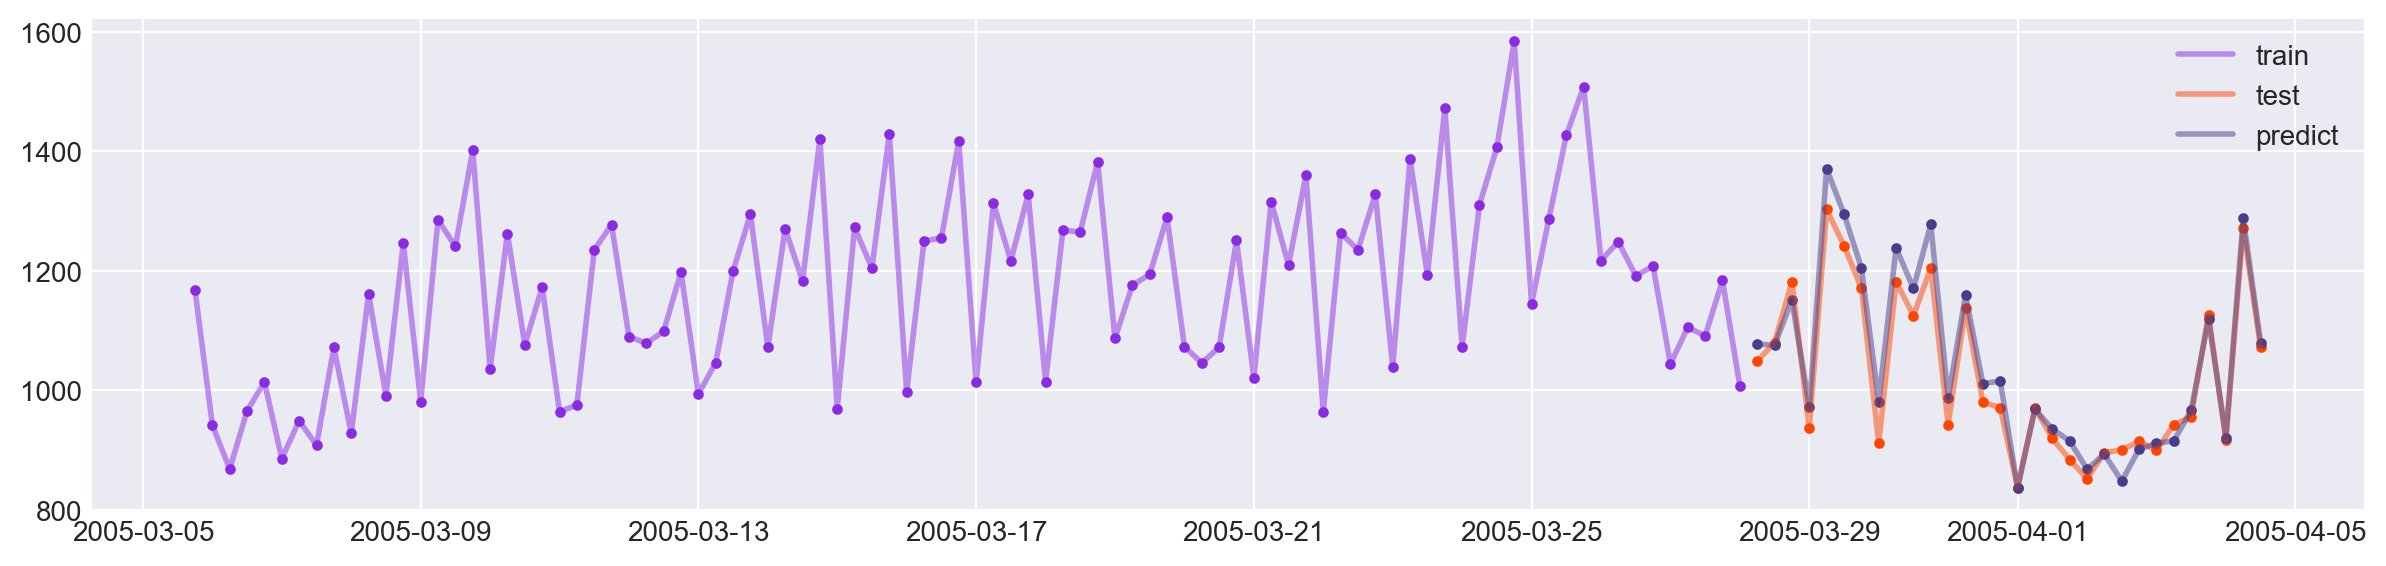

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [24]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 13s 50ms/step - loss: 125054.5469 - mae: 206.1317 - val_loss: 7140.8672 - val_mae: 77.6073
Epoch 2/20
200/200 [==============================] - 9s 46ms/step - loss: 3919.4868 - mae: 47.5498 - val_loss: 3189.7986 - val_mae: 49.8460
Epoch 3/20
200/200 [==============================] - 9s 46ms/step - loss: 2799.9570 - mae: 40.8947 - val_loss: 755.5735 - val_mae: 21.2741
Epoch 4/20
200/200 [==============================] - 9s 47ms/step - loss: 2281.8433 - mae: 36.7755 - val_loss: 904.0602 - val_mae: 25.1016
Epoch 5/20
200/200 [==============================] - 10s 48ms/step - loss: 1838.5245 - mae: 33.5909 - val_loss: 2797.9819 - val_mae: 46.5499
Epoch 6/20
200/200 [==============================] - 10s 49ms/step - loss: 1663.5615 - mae: 31.9808 - val_loss: 789.7383 - val_mae: 22.9320
Epoch 7/20
200/200 [==============================] - 10s 50ms/step - loss: 1738.1433 - mae: 30.3830 - val_loss: 1035.0800 - val_mae: 22.3731
Epoch 8/2

In [26]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

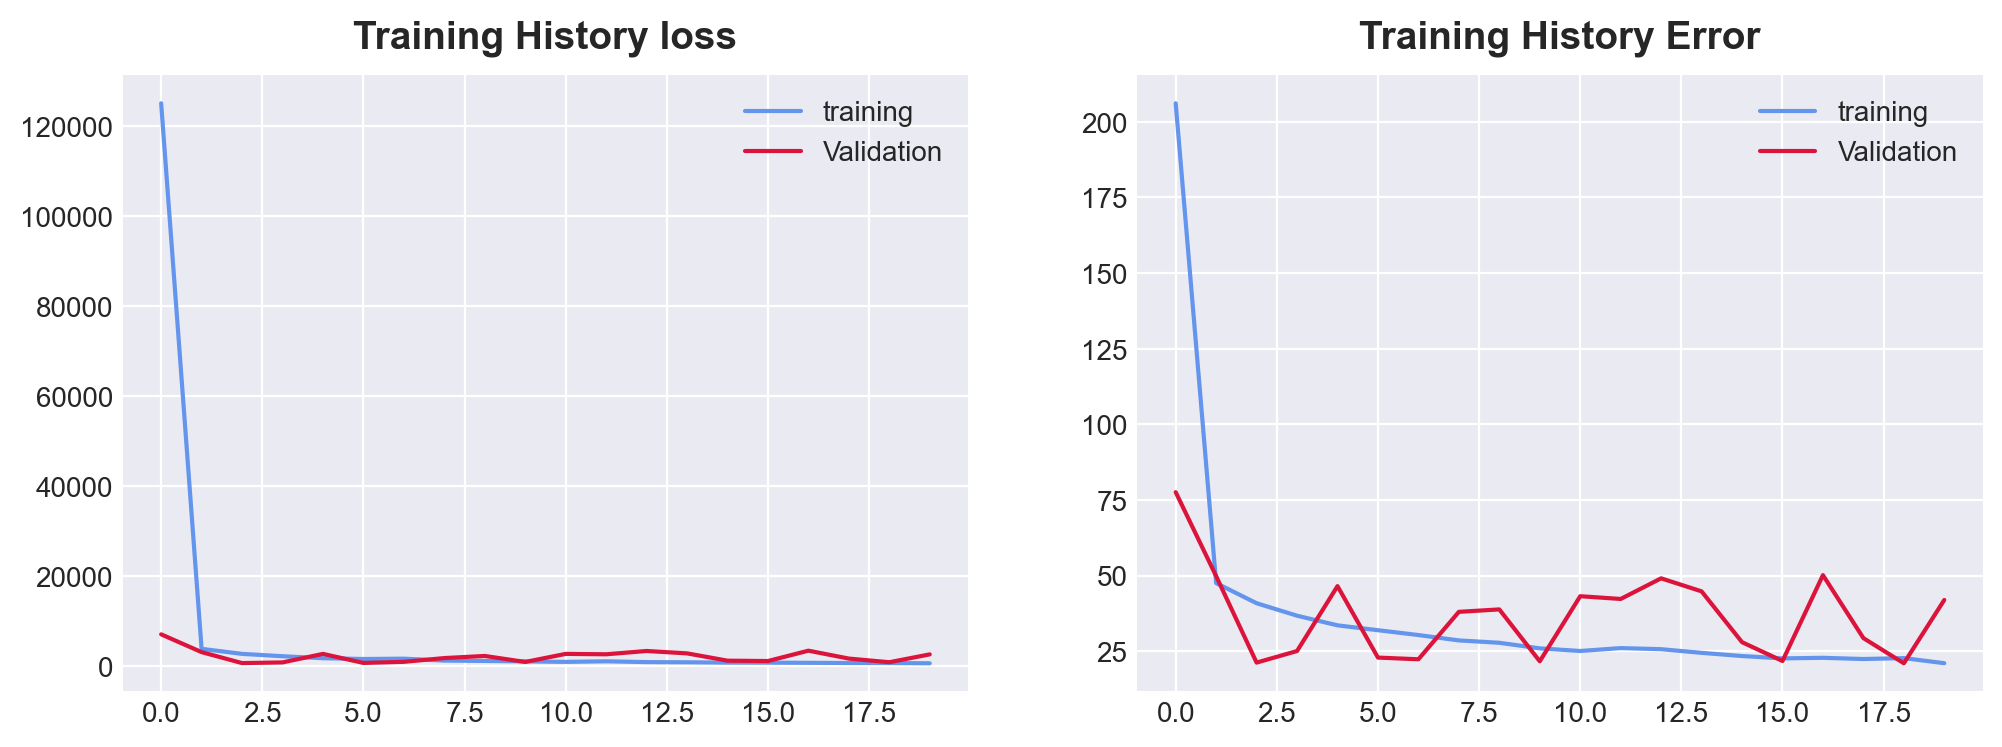

In [27]:
plot_tf_training_history(training_history)

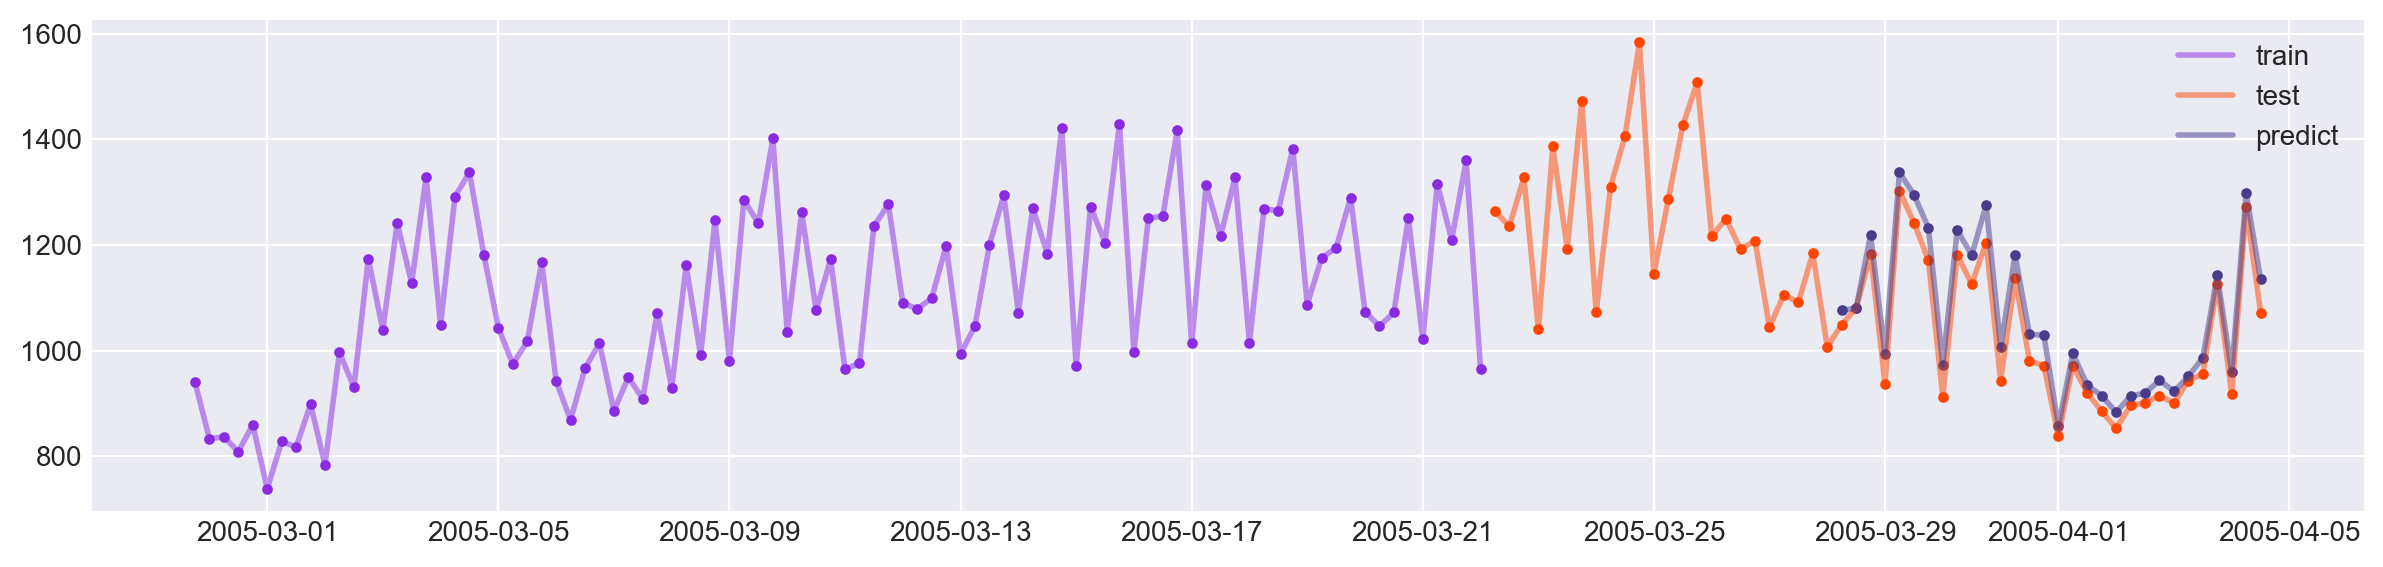

In [28]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [29]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,79.894444,9.916667,12.036102,31.227083,31.502607,30.513664,28.513243,41.982851
rmse,94.498003,38.617270,32.935860,37.079133,35.722256,36.479774,35.660690,51.868782
mape,0.080879,0.009331,0.011616,0.030586,0.030792,0.029707,0.027246,0.037644
r2,0.504966,0.917329,0.939865,0.923784,0.929260,0.926228,0.929503,0.917466


In [30]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,79.894444,94.498003,0.080879,0.504966
BayesianRidge,9.916667,38.617270,0.009331,0.917329
LassoCV,12.036102,32.935860,0.011616,0.939865
RandomForestRegressor,31.227083,37.079133,0.030586,0.923784
XGBRegressor,31.502607,35.722256,0.030792,0.929260
LGBMRegressor,30.513664,36.479774,0.029707,0.926228
CatBoostRegressor,28.513243,35.660690,0.027246,0.929503
LSTM_Dense,41.982851,51.868782,0.037644,0.917466


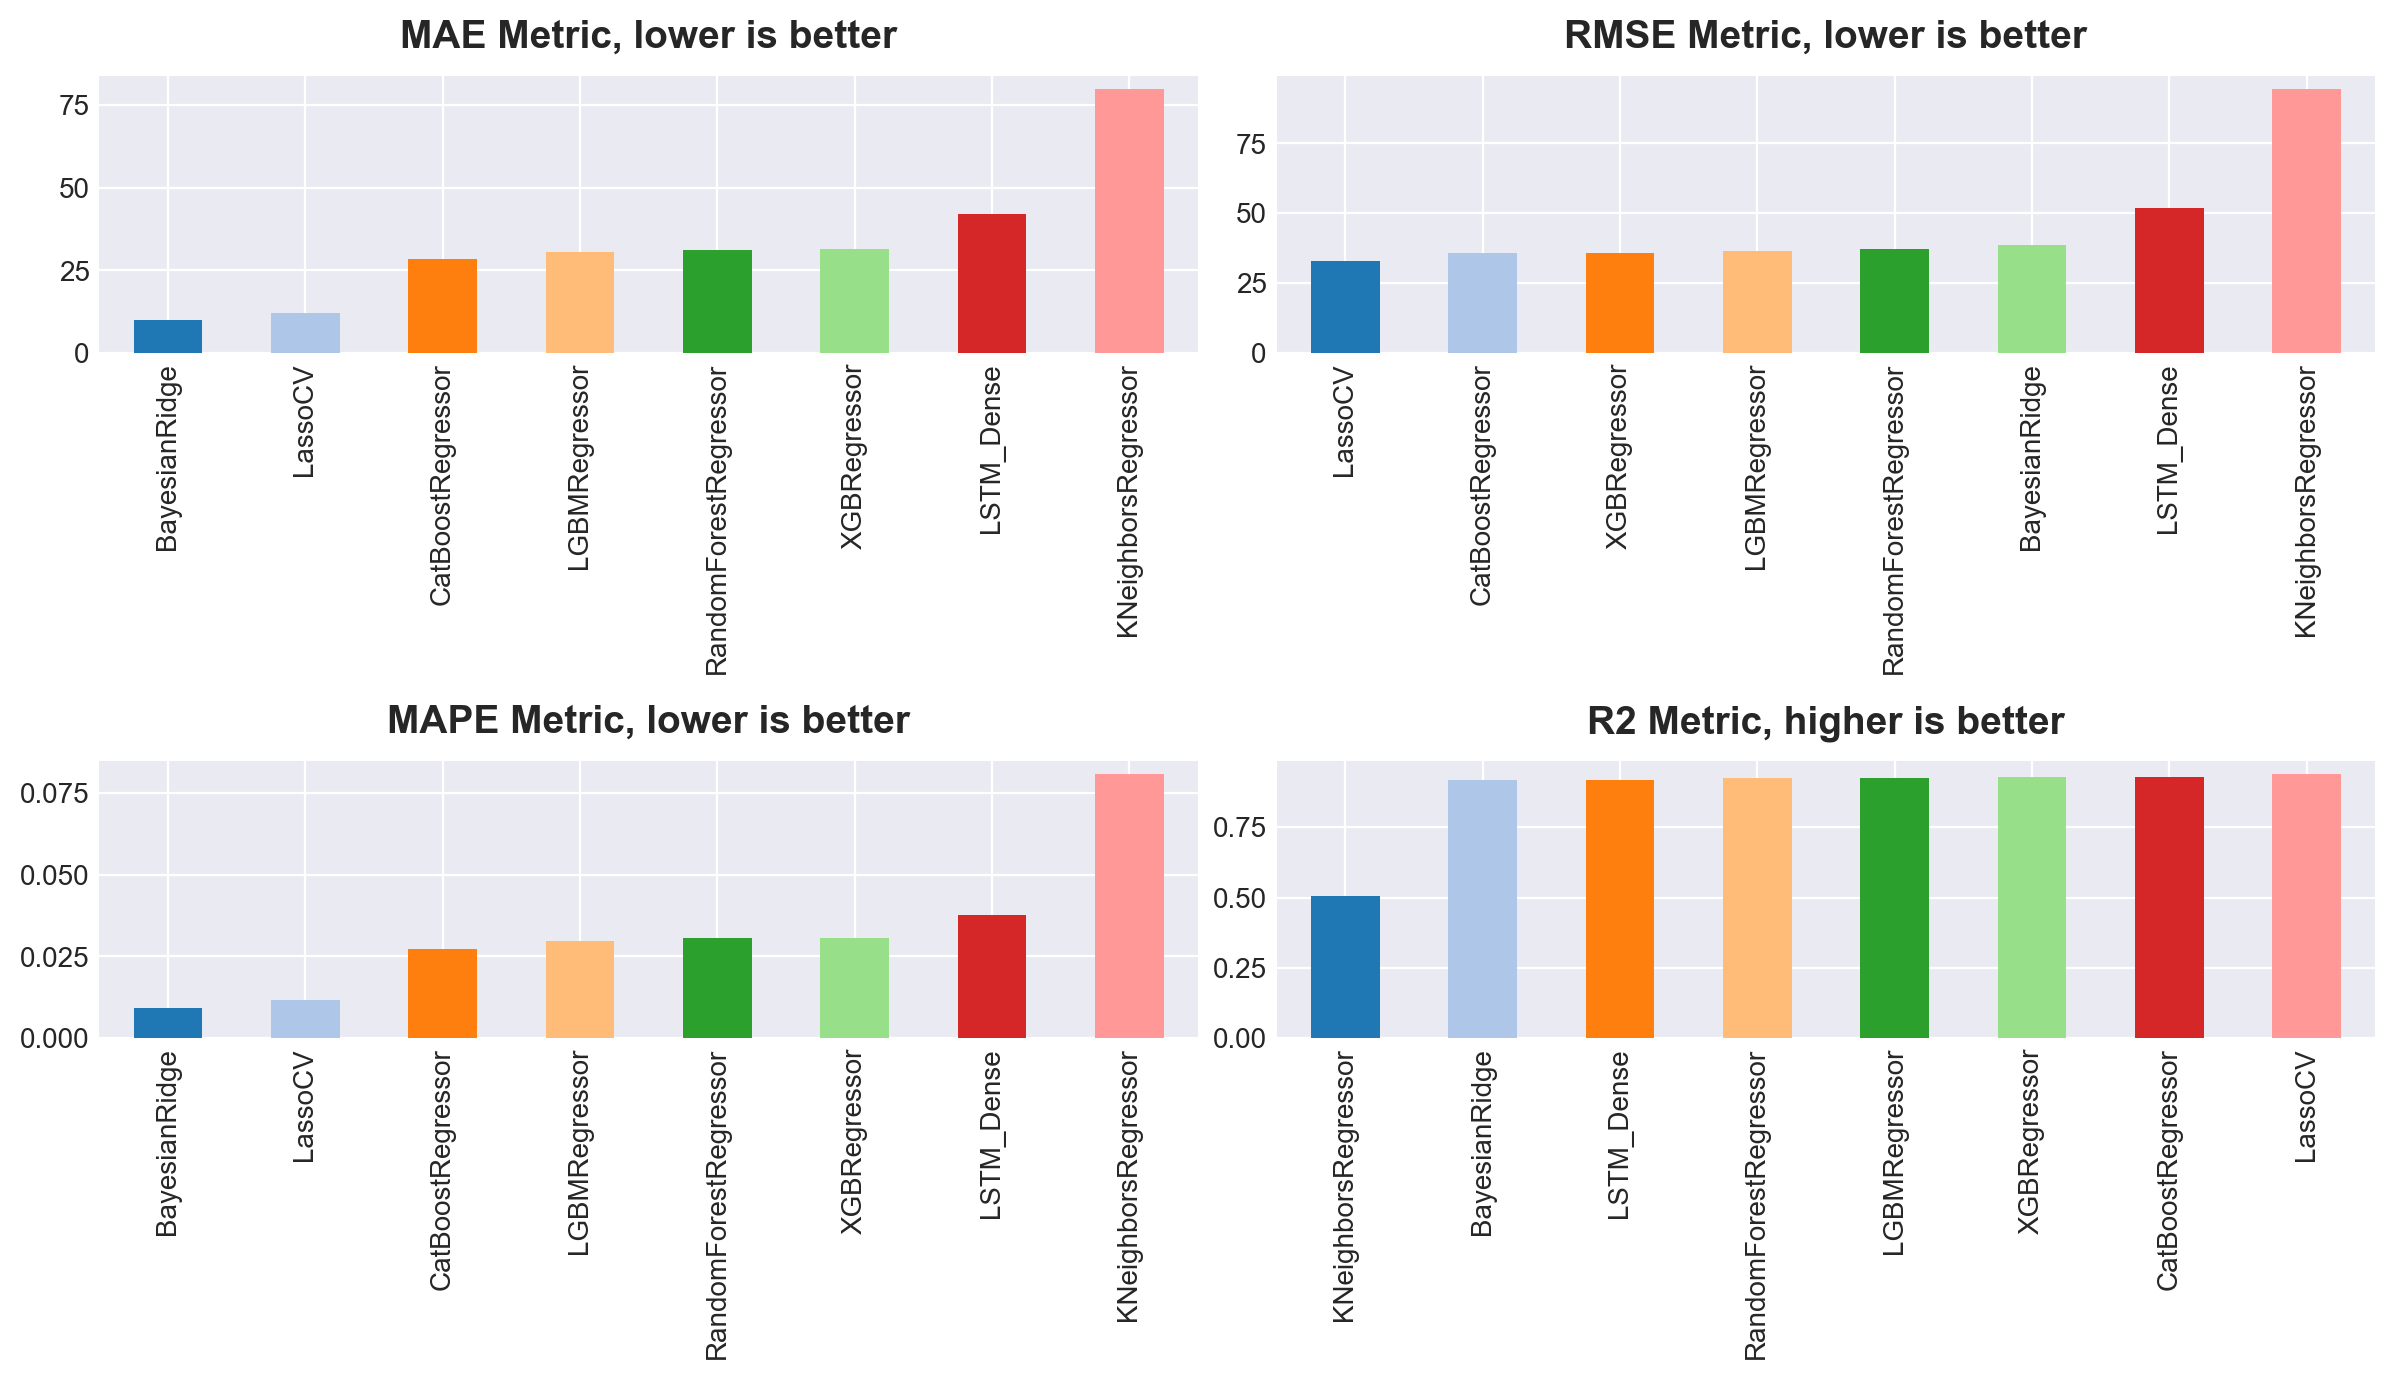

In [31]:
plot_metrics(resultsDF)

In [32]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Air_Quality"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)